In [1]:
%matplotlib inline

# Double Pendulum Example

The question this example solves is: given a double pendulum, at what *times* does the bottom pendulum **cross the Y axis**? 

At the same time this example shows how to solve the double pendulum in full coordinate space. This results in a dae system with two algebraic equation. We also use the jacobian to improve the results

The problem is easily stated: a first pendulum must move on a circle with
radius $l_1$ and has mass $m_1$, a second one is attached and must move on a circle
with radius $l_2$, it has a mass $m_2$, and the gravitational accelleration is $g$.
The Lagragian is
$$
    L = \frac{1}{2} m_1 (u_1^2 + v_1^2) - m_1 g y_1 + \frac{1}{2}m_2 (u_2^2 + v_2^2) - m_2 g y_2
            + \frac{\lambda_1}{2} (x_1^2+y_1^2 - l_1^2) + \frac{\lambda_2}{2} ((x_2-x_1)^2+(y_2-y_1)^2 - l_2^2),
$$
where $u$ and $v$ are used to indicate velocity. 
The last two terms are Lagrange multipliers following from the two constraints:
$x_1^2+y_1^2 - l_1^2 = 0$ and $(x_2-x_1)^2+(y_2-y_1)^2 - l_2^2 = 0$, which adds the two 
unkowns $\lambda_1$ and $\lambda_2$ to the system.

We arrive at the Euler-Lagrange differential equations for the problem, which
will have 8 DE and 2 constraints.
We add however two more constraints to the problem, following from deriving to
time the two known constraints:
$$x_1 u_1+y_1 v_1 = 0$$ 
and 
$$(x_2-x_1) (u_2-u_1)+(y_2-y_1) (v_2-v_1)=0.$$

These equations do not change the derived equations if their Lagrange multiplier
is supposed independent of time, as the terms they contribute
annihilate each other.
We introduce the Lagrange multipliers back into the residual by adding them
to the velocity terms as
$$ \frac{dx_1}{dt} = u1 - \lambda_i  x_1, ...$$
We arrive like this at the stablized index 2 double pendulum model.

An better alternative is to use an index 1 model, which does not need the stabilizing
terms. This leads to 8 DE, and 2 algebraic equations. These 2 follow from
deriving the two contraints *twice* to time, and replacing the second derivatives
by their definitions.

$$
\begin{array}{ll}
        0= m_1 \dot{u_1}        - \lambda_2 (x_1 - x_2)  - x_1 \lambda_1\\
        0= m_1 \dot{v_1} + g m_1 - \lambda_2 (y_1 - y_2)  - y_1 \lambda_1\\
        0= m_2 \dot{u_2}        + \lambda_2 (x_1 - x_2)\\
        0= m_2 \dot{v_2} + g m_2 + \lambda_2 (y_1 - y_2)\\
        0= \dot{x_1}-u_1\\
        0= \dot{y_1}-v_1\\
        0= \dot{x_2}-u_2\\
        0= \dot{y_2}-v_2\\
        0 = u_1^2 + v_1^2 + \frac{\lambda_1}{m_1} (x_1^2 + y_1^2) - g   y_1 + \frac{\lambda_2}{m_1} (x_1 (x_1-x_2) +  y_1 (y_1-y_2) )\\
        0 = (u_1-u_2)^2 + (v_1-v_2)^2  + \lambda_2 (\frac{1}{m_1}+\frac{1}{m_2}) ((x_1-x_2)^2 + (y_1-y_2)^2) + \frac{\lambda_1}{m_1}  (x_1 (x_1-x_2) + y_1 (y_1-y_2) )\\
\end{array}
$$

The solver used approximates the Jacobian if the Jacobian is not passed. As the Jacobian of the resulting
system is easily computed analytically, we can aid the solver by providing the
Jacobian. We conclude that we will need to solve an index 1 problem with the Jacobian
prescribed.

The algorithm first needs to find initial conditions for the derivatives,
then it solves the problem at hand. We take $g=9.8$, $m_1=2$, $m_2=1$, $l_1=5$, $l_2=2$,
where the initial position is at rest horizontally.

The algorithm computes the solution over 125 seconds, and plots the orbits of
the pendula, as well as the energy of the system (should be conserved at the
beginning value E=0).



In [2]:
from __future__ import print_function, division
import matplotlib.pyplot as plt
import numpy as np
from numpy import (arange, zeros, array, sin, cos, asarray, sqrt, pi, empty)
from scikits.odes import dae
from scikits.odes.sundials import ida

We use the following ordering in the array of unknowns:

array yy $[x_1, y_1, x_2, y_2, u_1, v_1, u_2, v_2, \lambda_1, \lambda_2]$

array yp $[\dot{x_1}, \dot{y_1}, \dot{x_2}, \dot{y_2}, \dot{u_1}, \dot{v_1}, \dot{u_2}, \dot{v_2}, \dot{\lambda_1}, \dot{\lambda_2}]$

In [3]:
#data of the pendulum
#class to hold the problem data
class Doublependulum():
    """ The problem class with the residual function and the constants defined
    """
    #default values
    deftend = 300.
    deftstep = 1e-2
    defx0 = 5
    defy0 = 0
    defx1 = 7
    defy1 = 0

    defg = 9.8
    defm1 = 2.0
    defm2 = 1.0
    defradius1 = 5.
    defradius2 = 2.

    def __init__(self, data=None):
        self.tend = Doublependulum.deftend
        self.tstep = Doublependulum.deftstep
        self.x0 = Doublependulum.defx0
        self.y0 = Doublependulum.defy0
        self.x1 = Doublependulum.defx1
        self.y1 = Doublependulum.defy1
        self.m1 = Doublependulum.defm1
        self.m2 = Doublependulum.defm2
        self.radius1 = Doublependulum.defradius1
        self.radius2 = Doublependulum.defradius2
        self.g = Doublependulum.defg

        #residual and jacabian function
        self.res = None
        self.jac = None

        if data is not None:
            self.tend = data.deftend
            self.tstep = data.deftstep
            self.x0 = data.x0
            self.y0 = data.y0
            self.x1 = data.x1
            self.y1 = data.y1
            self.m1 = data.m1
            self.m2 = data.m2
            self.radius1 = data.radius1
            self.radius2 = data.radius2
            self.g = data.g

        self.stop_t  = arange(.0, self.tend, self.tstep)

        # the index1 problem with jacobian :
        self.neq = 10
        #initial conditions
        lambdaval = 0.0
        self.z0 =  array([self.x0, self.y0, self.x1, self.y1, 0., 0., 0.,
                          0., lambdaval, lambdaval])
        self.zprime0 = array([0., 0., 0., 0., -lambdaval*self.x0,
                              -lambdaval*self.y0-self.g,
                              -lambdaval*self.x1,
                              -lambdaval*self.y1-self.g, 0., 0.], float)
        self.algvar_idx = [8, 9]
        self.algvar = array([1, 1, 1, 1, 1, 1, 1, 1, -1, -1])
        self.exclalg_err = False

    def set_res(self, resfunction):
        """Function to set the resisual function as required by IDA"""
        self.res = resfunction

    def set_jac(self, jacfunction):
        """Function to set the resisual function as required by IDA"""
        self.jac = jacfunction


The ida interface allows to use classes as residual and jacobian function. This has the benefit that local data can be used. For this, you inherit your classes from *ida.IDA_RhsFunction* and *ida.IDA_JacRhsFunction* and provide an evaluate function with a specific signature.

In [4]:
# we now consider the residual and jacobian functions

class resindex1(ida.IDA_RhsFunction):
    """ Residual function class as needed by the IDA DAE solver"""

    def set_dblpend(self, dblpend):
        """ Set the double pendulum problem to solve to have access to
            the data """
        self.dblpend = dblpend

    def evaluate(self, tres, yy, yp, result, userdata):
        m1 = self.dblpend.m1
        m2 = self.dblpend.m2
        g = self.dblpend.g

        result[0]= m1*yp[4]        - yy[9]*(yy[0] - yy[2])  - yy[0]*yy[8]
        result[1]= m1*yp[5] + g*m1 - yy[9]*(yy[1] - yy[3])  - yy[1]*yy[8]
        result[2]= m2*yp[6]        + yy[9]*(yy[0] - yy[2])
        result[3]= m2*yp[7] + g*m2 + yy[9]*(yy[1] - yy[3])
        result[4]= yp[0] - yy[4]
        result[5]= yp[1] - yy[5]
        result[6]= yp[2] - yy[6]
        result[7]= yp[3] - yy[7]
        result[8] = yy[4]**2 + yy[5]**2 + yy[8]/m1*(yy[0]**2 + yy[1]**2) \
                    - g * yy[1] + yy[9]/m1 *(yy[0]*(yy[0]-yy[2]) +
                                            yy[1]*(yy[1]-yy[3]) )
        result[9] = (yy[4]-yy[6])**2 + (yy[5]-yy[7])**2 \
                  + yy[9]*(1./m1+1./m2)*((yy[0]-yy[2])**2 + (yy[1]-yy[3])**2)\
                  + yy[8]/m1 *(yy[0]*(yy[0]-yy[2]) + yy[1]*(yy[1]-yy[3]) )
        return 0

class jacindex1(ida.IDA_JacRhsFunction):

    def set_dblpend(self, dblpend):
        """ Set the double pendulum problem to solve to have access to
            the data """
        self.dblpend = dblpend

    def evaluate(self, tres, yy, yp, cj, jac):

        m1 = self.dblpend.m1
        m2 = self.dblpend.m2
        g = self.dblpend.g
        jac[:,:] = 0.
        jac[0][0] = - yy[9]   - yy[8]
        jac[0][2] =  yy[9]
        jac[0][4] = cj * m1
        jac[0][8] = - yy[0]
        jac[0][9] = - (yy[0] - yy[2])
        jac[1][1] = - yy[9] - yy[8]
        jac[1][3] = yy[9]
        jac[1][5] = cj * m1
        jac[1][8] = - yy[1]
        jac[1][9] = - (yy[1] - yy[3])
        jac[2][0] = yy[9]
        jac[2][2] = -yy[9]
        jac[2][6] = cj * m2
        jac[2][9] = (yy[0] - yy[2])
        jac[3][1] = yy[9]
        jac[3][3] = -yy[9]
        jac[3][7] = cj * m2
        jac[3][9] = (yy[1] - yy[3])
        jac[4][0] = cj
        jac[4][4] = -1
        jac[5][1] = cj
        jac[5][5] = -1
        jac[6][2] = cj
        jac[6][6] = -1
        jac[7][3] = cj
        jac[7][7] = -1
        jac[8][0] = (yy[8]+yy[9])/m1*2*yy[0] - yy[9]/m1 * yy[2]
        jac[8][1] = (yy[8]+yy[9])/m1*2*yy[1] - yy[9]/m1 * yy[3] - g
        jac[8][2] = - yy[9]/m1 * yy[0]
        jac[8][3] = - yy[9]/m1 * yy[1]
        jac[8][4] = 2*yy[4]
        jac[8][5] = 2*yy[5]
        jac[8][8] = 1./m1*(yy[0]**2 + yy[1]**2)
        jac[8][9] = 1./m1 *(yy[0]*(yy[0]-yy[2]) + yy[1]*(yy[1]-yy[3]) )
        jac[9][0] = yy[9]*(1./m1+1./m2)*2*(yy[0]-yy[2]) + \
                    yy[8]/m1 *(2*yy[0] - yy[2])
        jac[9][1] = yy[9]*(1./m1+1./m2)*2*(yy[1]-yy[3]) + \
                    yy[8]/m1 *(2*yy[1] - yy[3])
        jac[9][2] = - yy[9]*(1./m1+1./m2)*2*(yy[0]-yy[2]) - \
                    yy[8]/m1 * yy[0]
        jac[9][3] = - yy[9]*(1./m1+1./m2)*2*(yy[1]-yy[3])
        jac[9][4] = 2*(yy[4]-yy[6])
        jac[9][5] = 2*(yy[5]-yy[7])
        jac[9][6] = -2*(yy[4]-yy[6])
        jac[9][7] = -2*(yy[5]-yy[7])
        jac[9][8] = 1./m1 *(yy[0]*(yy[0]-yy[2]) + yy[1]*(yy[1]-yy[3]) )
        jac[9][9] = (1./m1+1./m2)*((yy[0]-yy[2])**2 + (yy[1]-yy[3])**2)
        return 0


We want to determine when and how the bottom pendulum crosses the Y axis. Crossing the Y axis means $x_1=0$, which is the third unknown in the equations, so we define a root function to pass to the solver:

In [5]:
#  a root function has a specific signature. Result will be of size nr_rootfns, and must be filled with the result of the 
#  function that is observed to determine if a root is present.
def crosses_Y(t, yy, yp, result, user_data):
    result[0] = yy[2]


To solve the DAE you define a dae object, specify the solver to use, here ida, and pass the residual function and if available the jacobian.
As we use classes for our functions to have access to user data, we need to instantiate them first. 

In [6]:
problem = Doublependulum()
res = resindex1()
jac = jacindex1()
res.set_dblpend(problem)
jac.set_dblpend(problem)
solver = dae('ida', res, 
             compute_initcond='yp0',
             first_step_size=1e-18,
             atol=1e-10,
             rtol=1e-8,
             max_steps=5000,
             jacfn=jac,
             algebraic_vars_idx=problem.algvar_idx,
             exclude_algvar_from_error=problem.exclalg_err,
             rootfn=crosses_Y, nr_rootfns=1,
             old_api=False)

We can now sove the problem stepwise. 

In [7]:
#storage of solution
x1t = np.empty(len(problem.stop_t), float)
y1t = np.empty(len(problem.stop_t), float)
x2t = np.empty(len(problem.stop_t), float)
y2t = np.empty(len(problem.stop_t), float)
xp1t = np.empty(len(problem.stop_t), float)
yp1t = np.empty(len(problem.stop_t), float)
xp2t = np.empty(len(problem.stop_t), float)
yp2t = np.empty(len(problem.stop_t), float)

sol = solver.init_step(0., problem.z0, problem.zprime0)
if sol.errors.t:
    print('Error in determination init condition')
    print(sol.message)
else:
    ind = 0
    x1t[ind] = sol.values.y[0]
    y1t[ind] = sol.values.y[1]
    x2t[ind] = sol.values.y[2]
    y2t[ind] = sol.values.y[3]
    xp1t[ind] = sol.values.ydot[0]
    yp1t[ind] = sol.values.ydot[1]
    xp2t[ind] = sol.values.ydot[2]
    yp2t[ind] = sol.values.ydot[3]

lastind = len(problem.stop_t)
for index,time in enumerate(problem.stop_t[1:]):
    #print 'at time', time
    sol = solver.step(time)
    if sol.errors.t:
        lastind = index+1
        print('Error in solver, breaking solution at time %g' % time)
        print(sol.message)
        break
    ind = index + 1
    x1t[ind] = sol.values.y[0]
    y1t[ind] = sol.values.y[1]
    x2t[ind] = sol.values.y[2]
    y2t[ind] = sol.values.y[3]
    xp1t[ind] = sol.values.ydot[0]
    yp1t[ind] = sol.values.ydot[1]
    xp2t[ind] = sol.values.ydot[2]
    yp2t[ind] = sol.values.ydot[3]

energy = problem.m1*problem.g*y1t + \
            problem.m2*problem.g*y2t + \
            .5 *(problem.m1 * (xp1t**2 + yp1t**2)
                 + problem.m2 * (xp2t**2 + yp2t**2) )

test 5.0 0 [ 5.  0.  7.  0.  0.  0.  0.  0.  0.  0.]
Error in solver, breaking solution at time 263.88
Could not reach endpoint


The solver can't obtain a solution with the required precision after a certain time. Increasing *max_steps* would allow to compute longer.

A plot of the movement at the start, and of the envergy over the computed duration goes as follows:

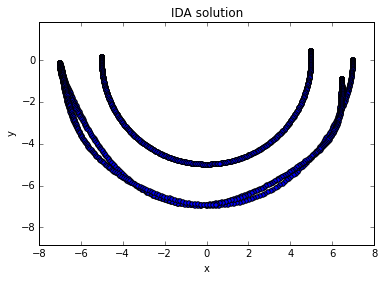

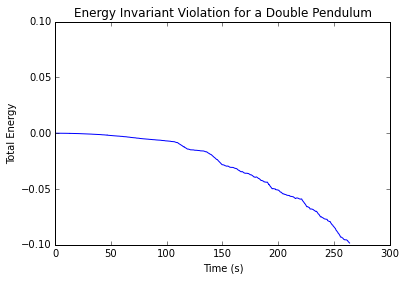

In [8]:
# quick plot:
plt.figure(1)
plt.title('IDA solution')
plt.scatter(x1t[:min(lastind,1000)], y1t[:min(lastind,1000)])
plt.scatter(x2t[:min(lastind,1000)], y2t[:min(lastind,1000)])
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-10, 10)
plt.ylim(-8, 2)
plt.axis('equal')

plt.figure(2)
plt.plot(problem.stop_t[:lastind], energy[:lastind], 'b')
plt.ylim(-0.1, 0.1)
plt.title('Energy Invariant Violation for a Double Pendulum')
plt.xlabel('Time (s)')
plt.ylabel('Total Energy')
plt.axis()
plt.show()

From the total energy we can see the deviation from the true solution.

Next, consider the roots, and let us plot some of them:

We have found 99 crossings of the Y axis
Some of the different configutations when crossing the Y axis are:


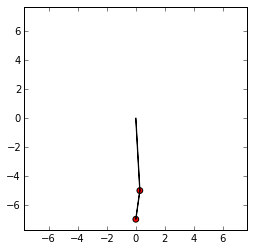

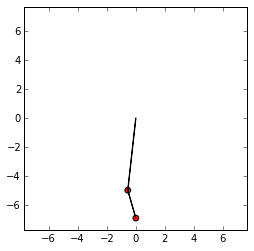

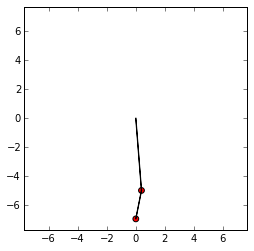

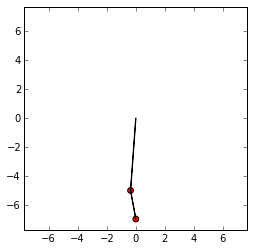

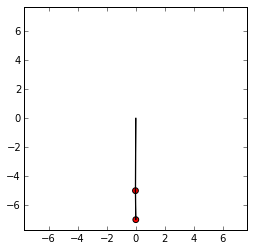

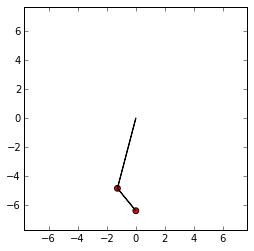

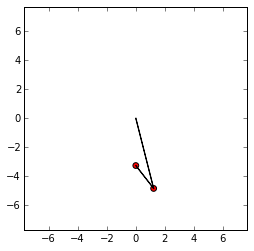

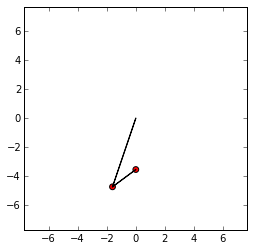

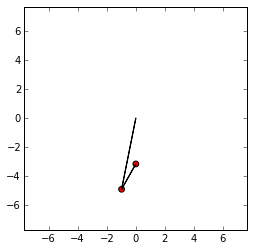

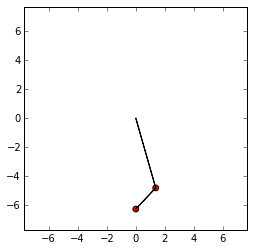

In [9]:
%run 'mpl_animation_html.ipynb'

print ('We have found %d crossings of the Y axis' % len(sol.roots.t))
print ('Some of the different configutations when crossing the Y axis are:')

def drawonesol(nr):
    artist1, = circle(ax, sol.roots.y[nr][0], sol.roots.y[nr][1], rad)
    artist2, = circle(ax, sol.roots.y[nr][2], sol.roots.y[nr][3], rad)
    artist3, = line(ax, 0, 0, sol.roots.y[nr][0], sol.roots.y[nr][1])
    artist4, = line(ax, sol.roots.y[nr][0], sol.roots.y[nr][1], sol.roots.y[nr][2], sol.roots.y[nr][3])
    return (artist3, artist4,artist1, artist2)

sizex = (problem.radius1+problem.radius2)*1.1
sizey = (problem.radius1+problem.radius2)*1.1
rad = problem.radius2*0.1


for ind in np.arange(0,len(sol.roots.t),10):
    fig = plt.figure()
    ax = plt.axes(aspect='equal', xlim=(-sizex, sizex), ylim=(-sizey, sizey))
    arts = drawonesol(ind)
    #plt.plot(arts)

# Animation of the double pendulum
No example of the pendulum is complete without an animation. Having fixed timestep output is ideal to create realistic animations of physical processes. We show at 10 frames per second the first 20 seconds next.

In [13]:
%run 'mpl_animation_html.ipynb'

import matplotlib
import matplotlib.animation as animation

In [14]:
time = 0.
endtime = 40.
frames_per_second = 10.
timestep = 1/frames_per_second
skipsteps = int(round(timestep/problem.tstep))


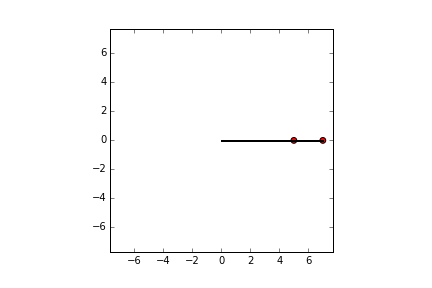
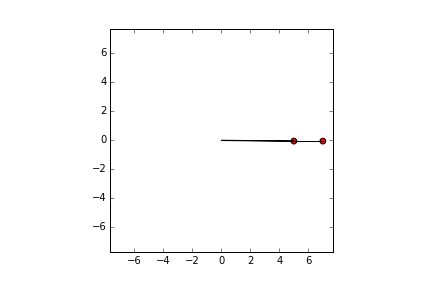
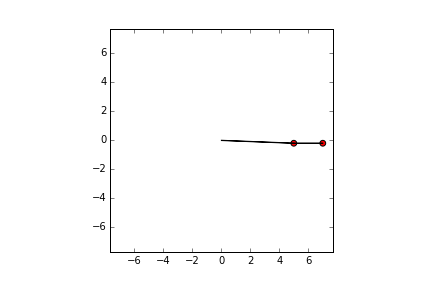
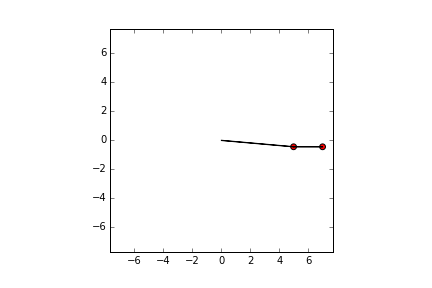
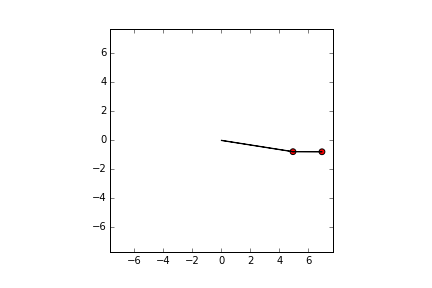
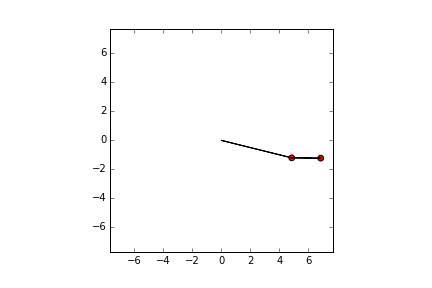
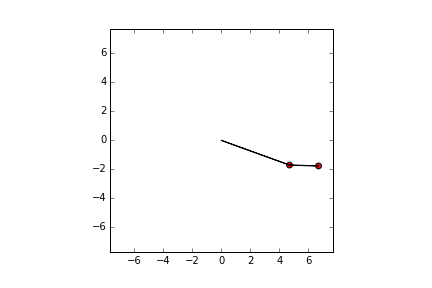
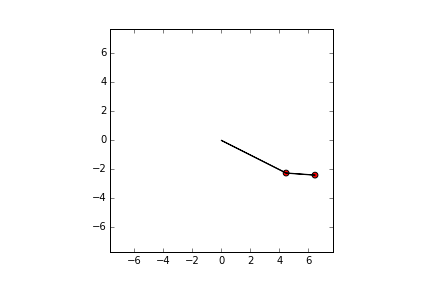
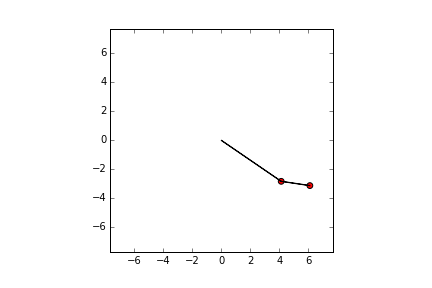
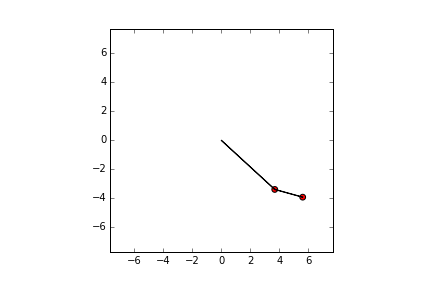
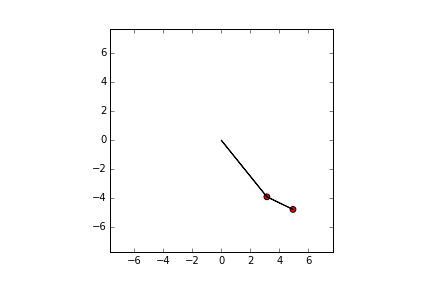
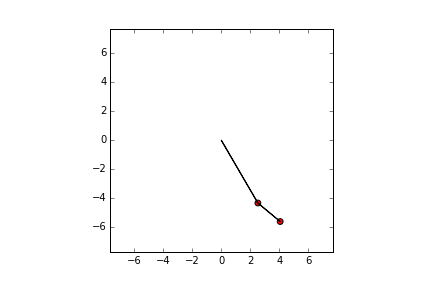
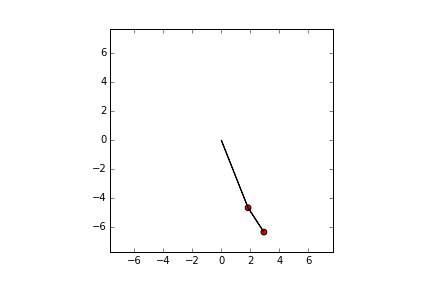
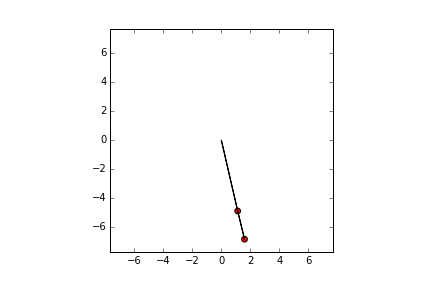
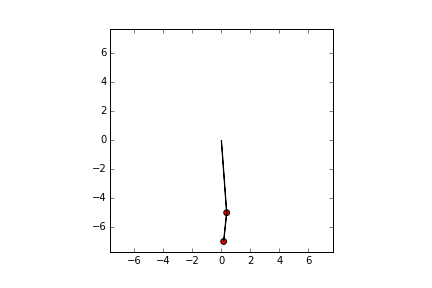
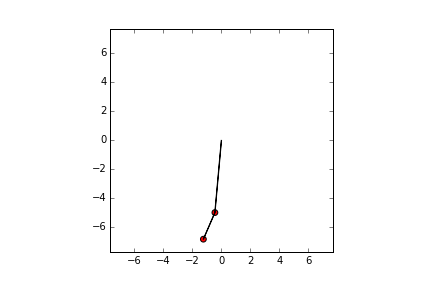
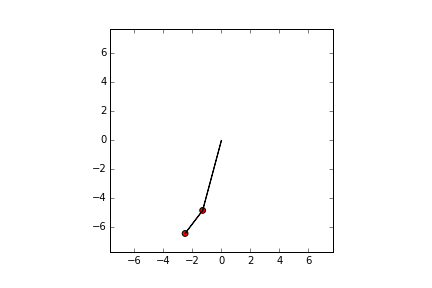
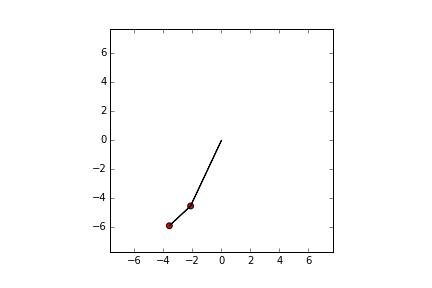
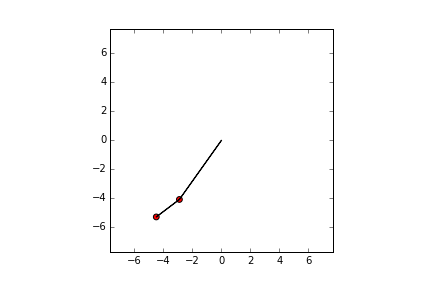
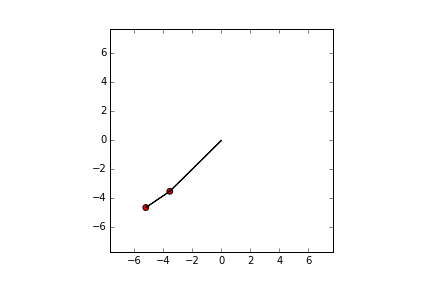
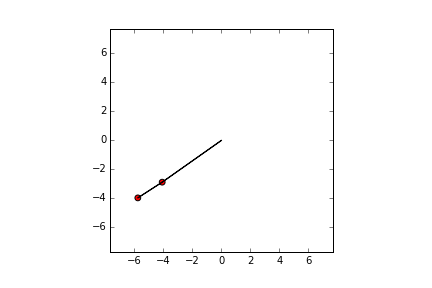
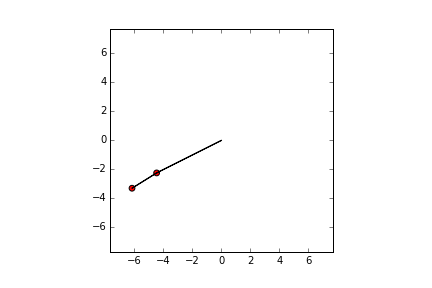
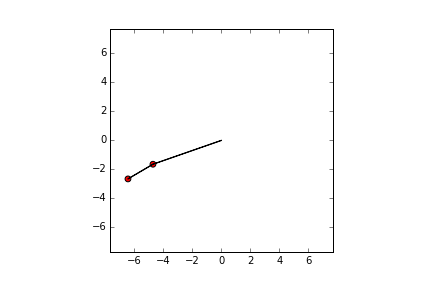
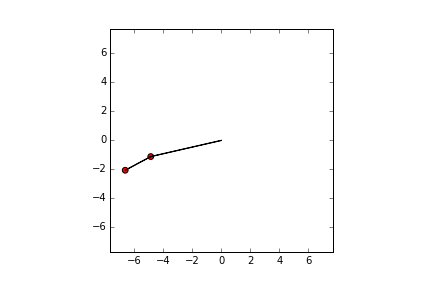
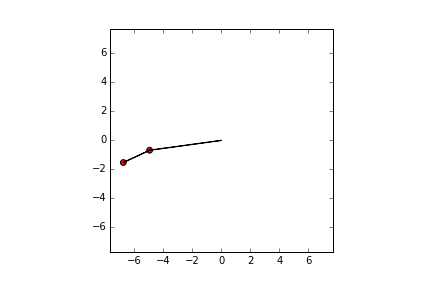
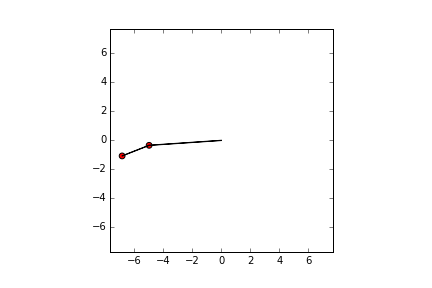
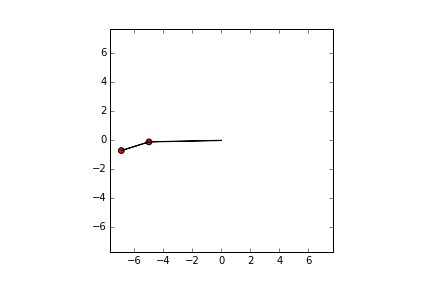
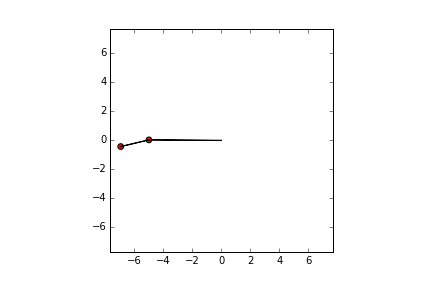
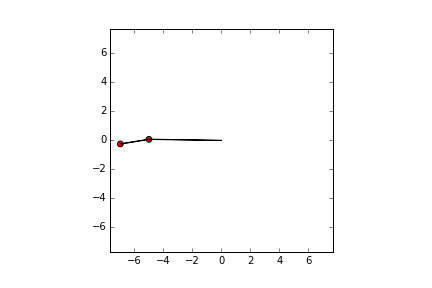
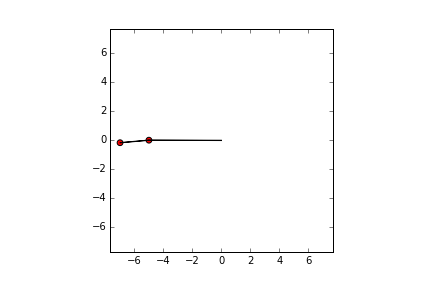
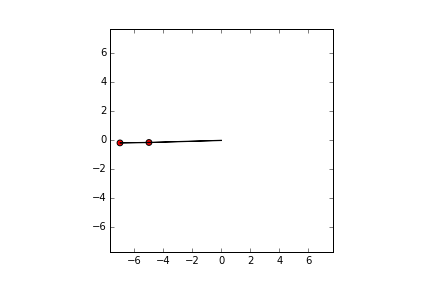
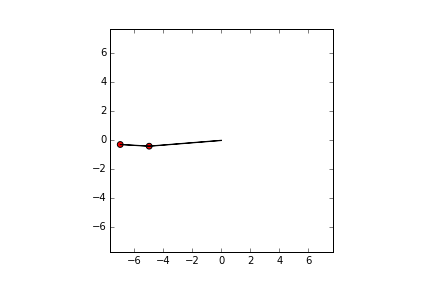
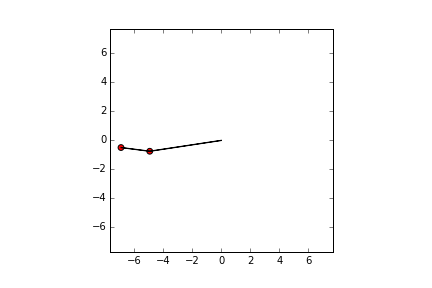
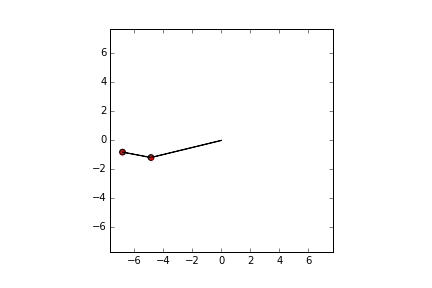
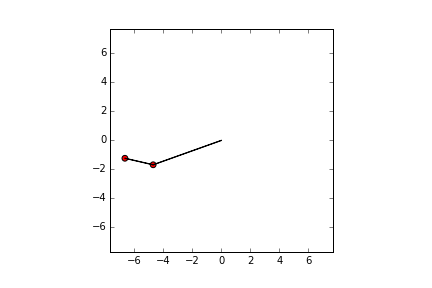
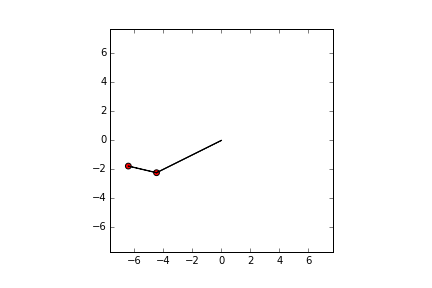
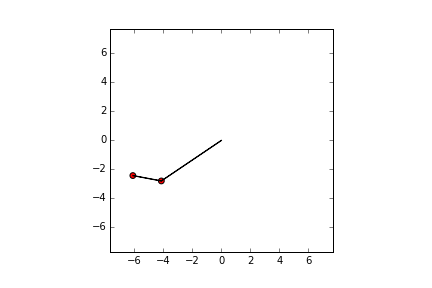
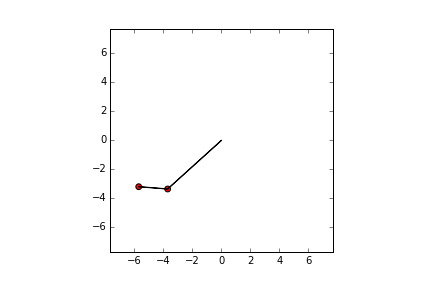
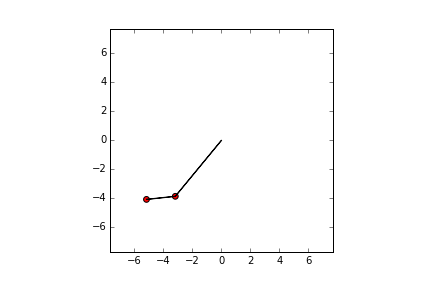
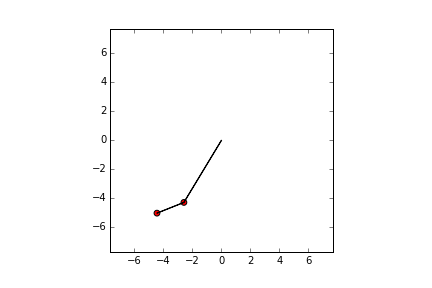
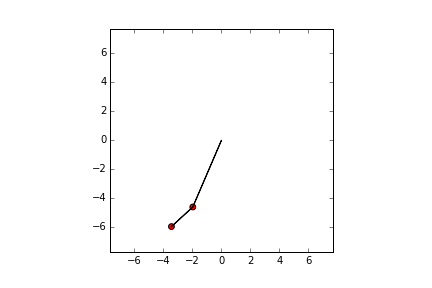
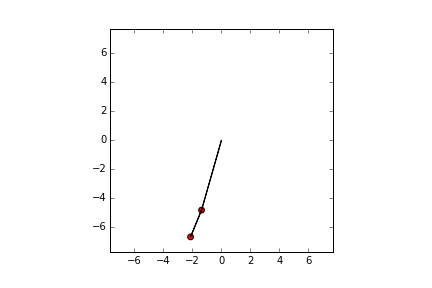
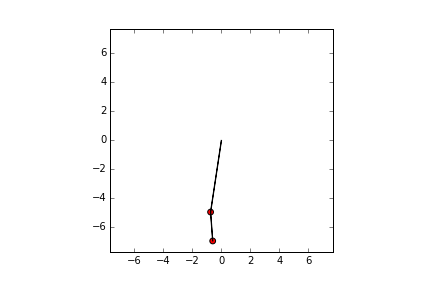
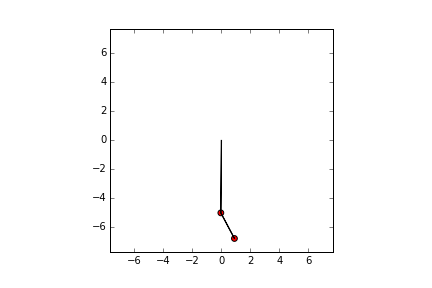
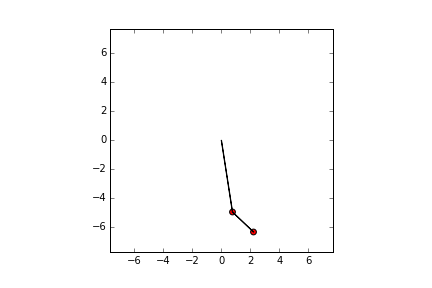
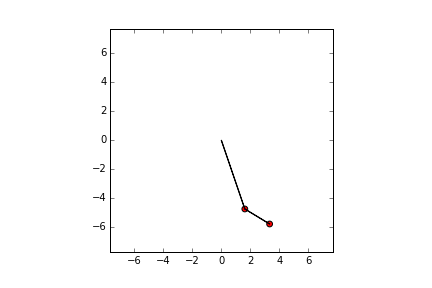
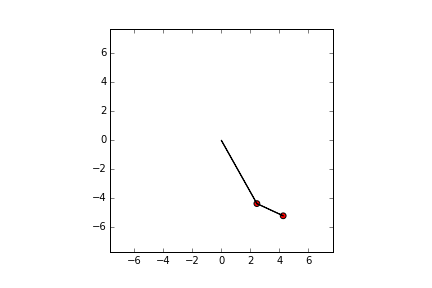
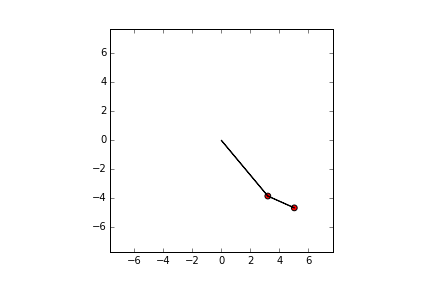
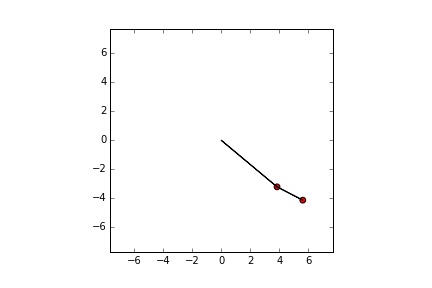
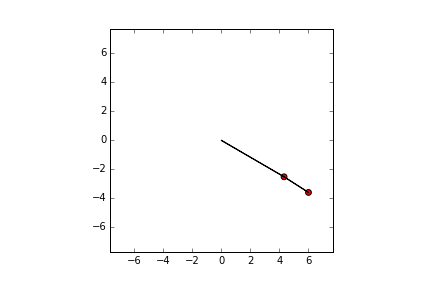
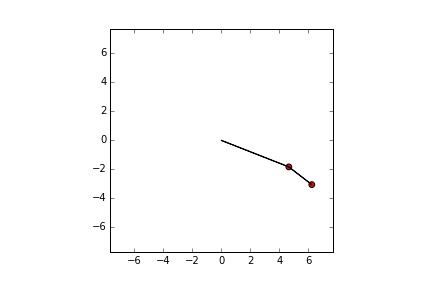
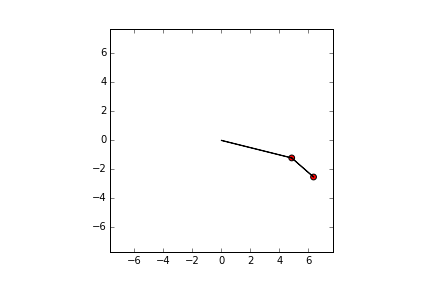
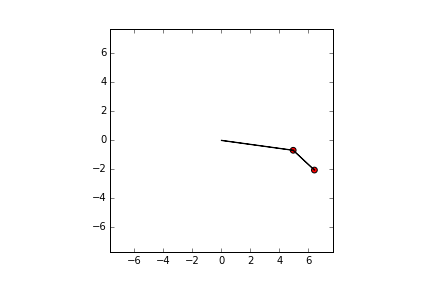
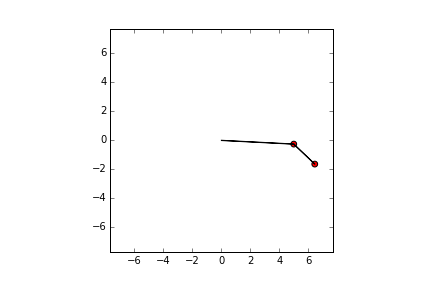
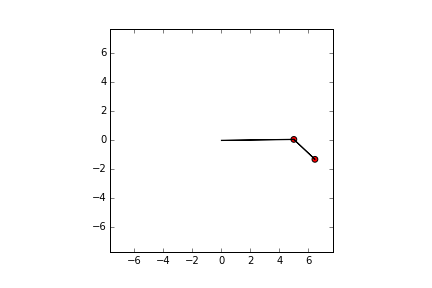
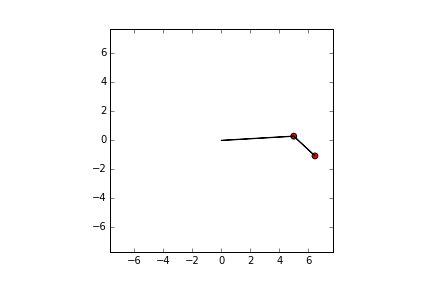
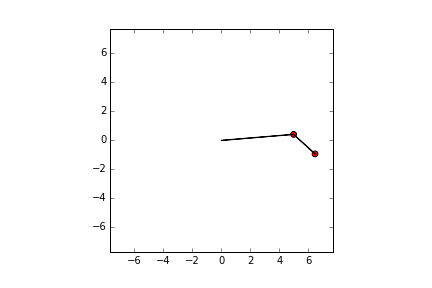
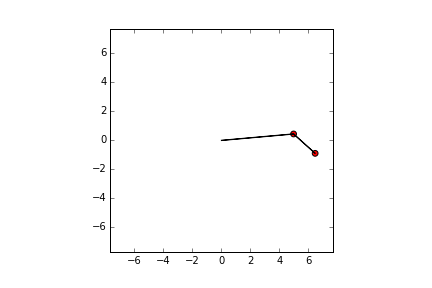
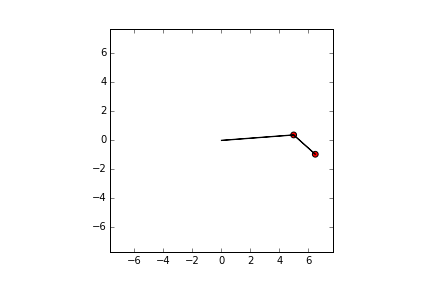
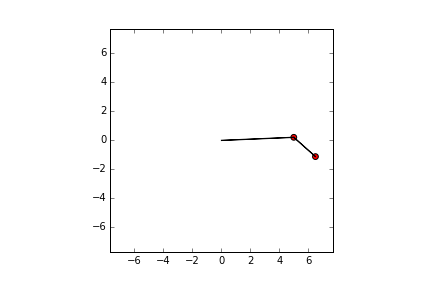
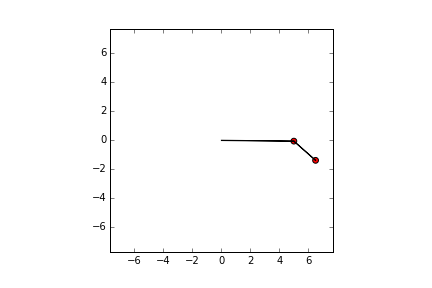
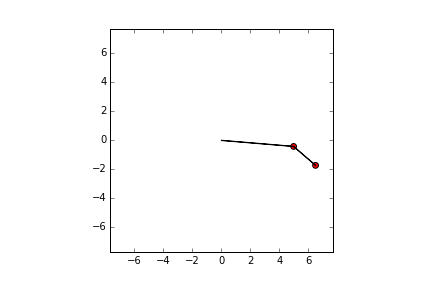
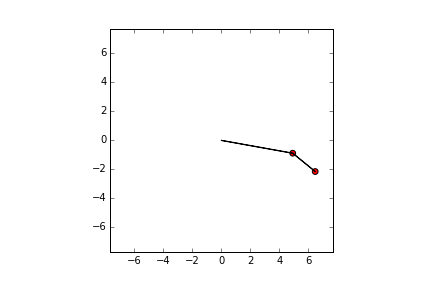
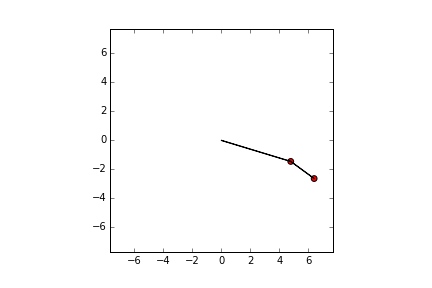
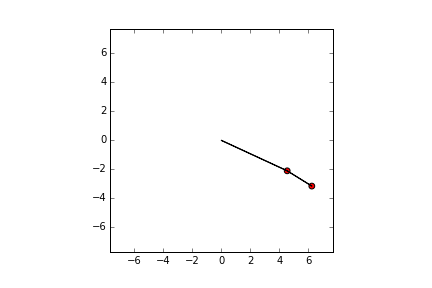
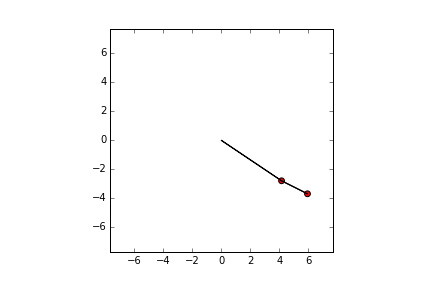
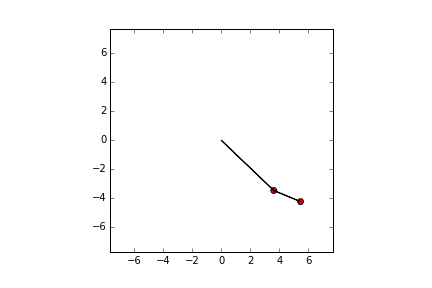
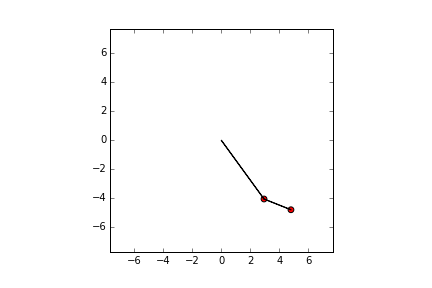
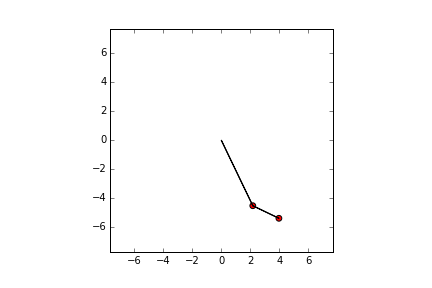
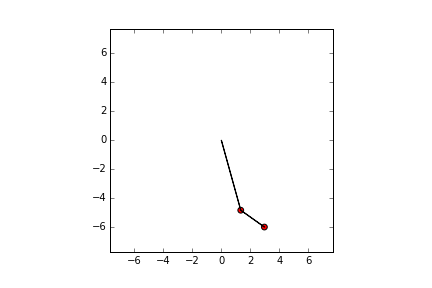
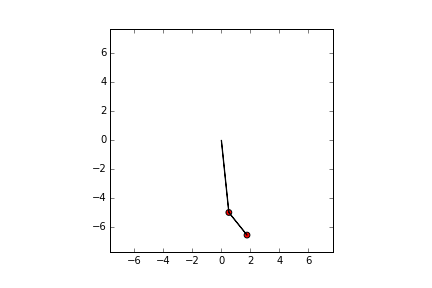
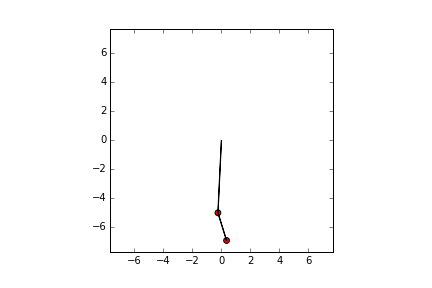
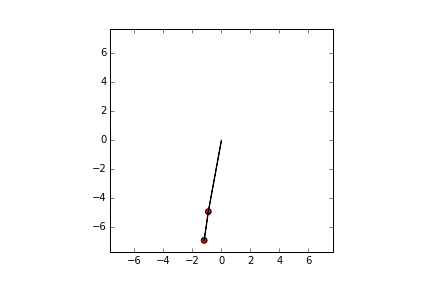
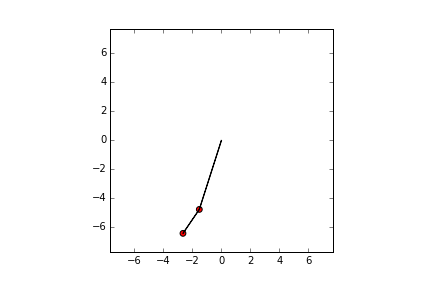
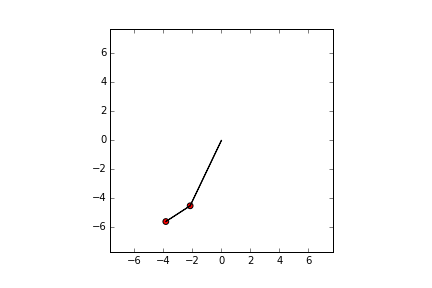
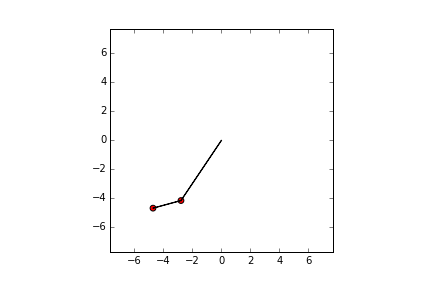
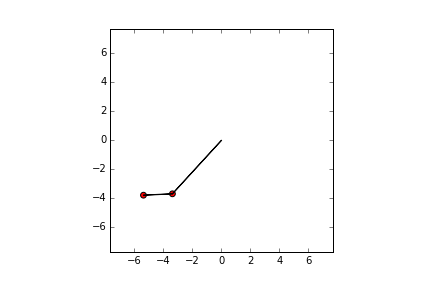
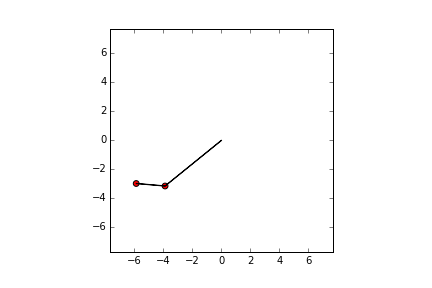
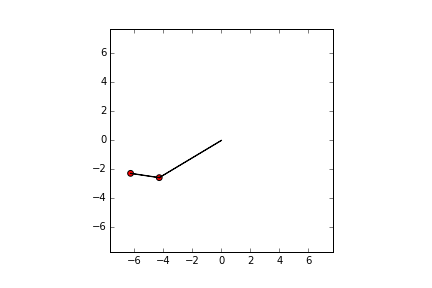
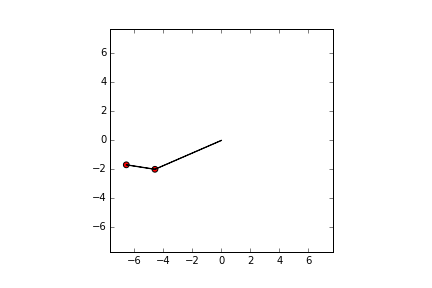
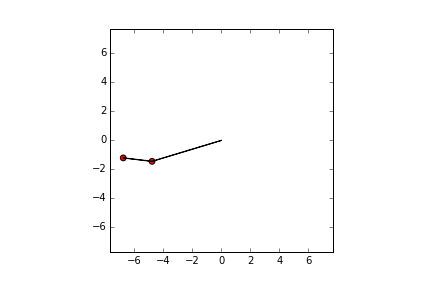
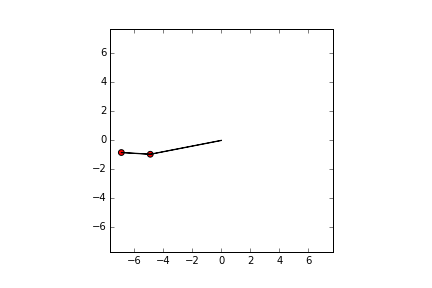
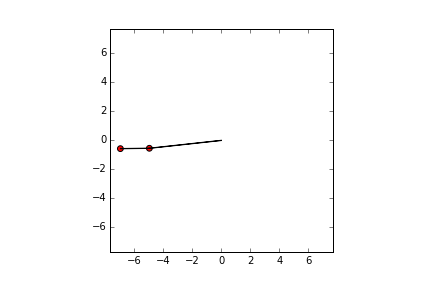
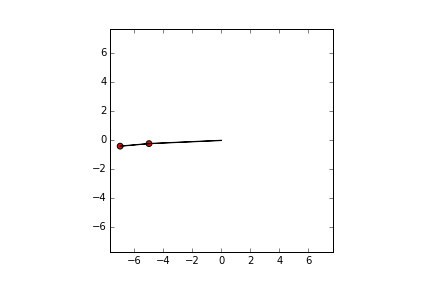
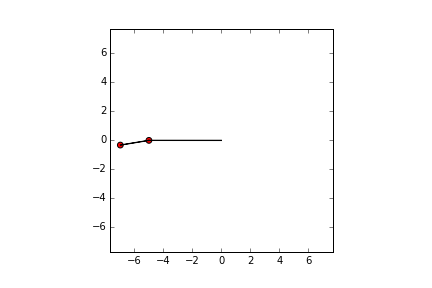
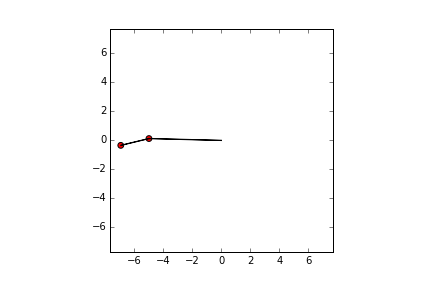
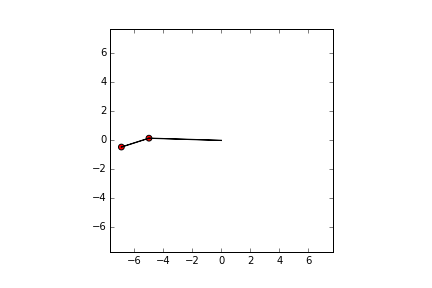
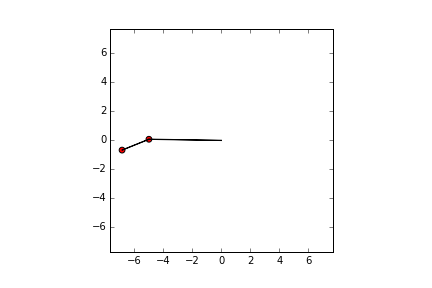
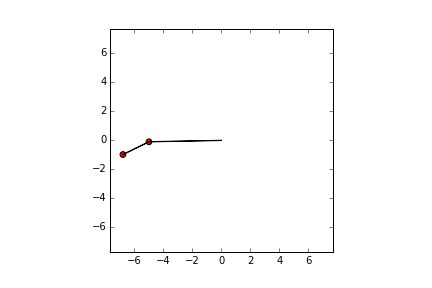
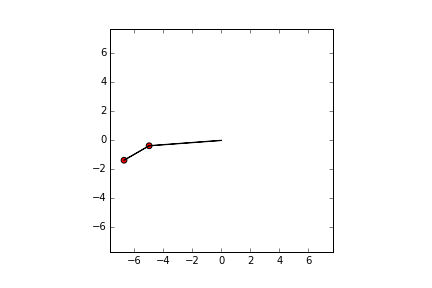
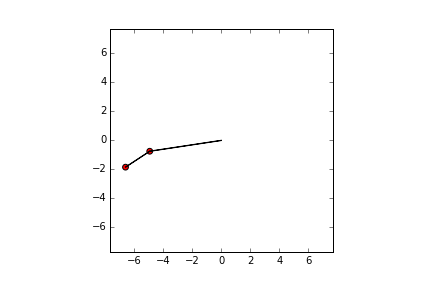
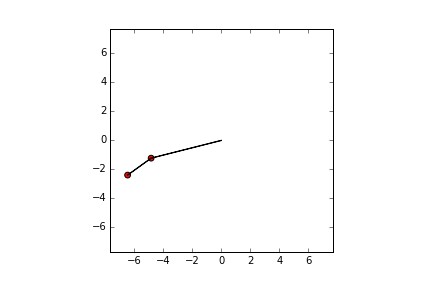
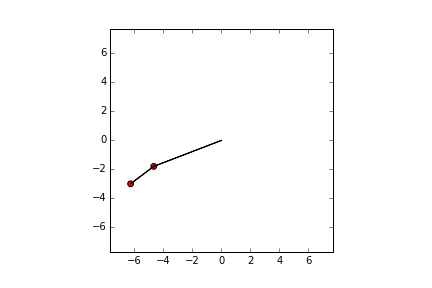
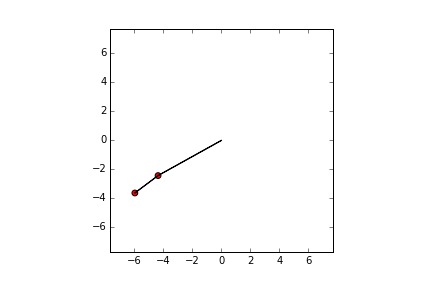
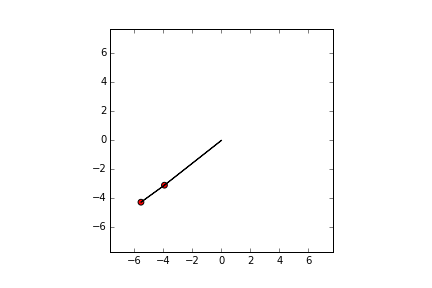
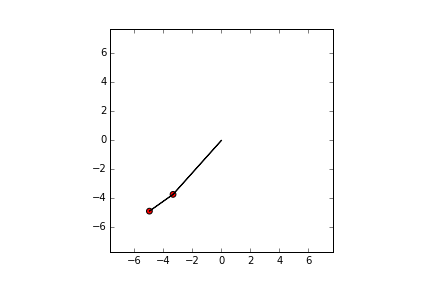
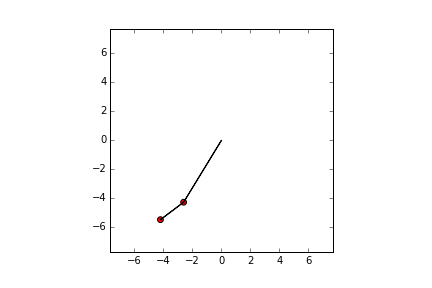
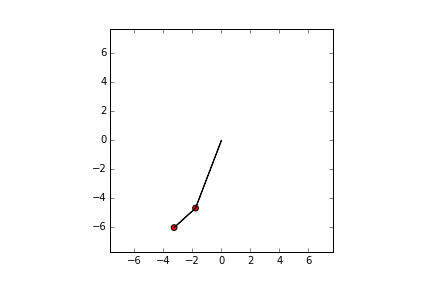
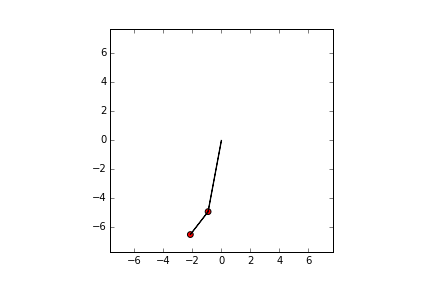
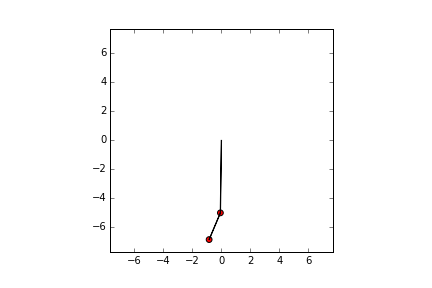
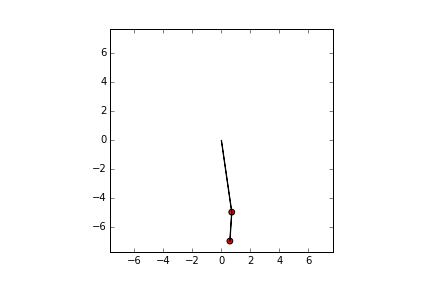
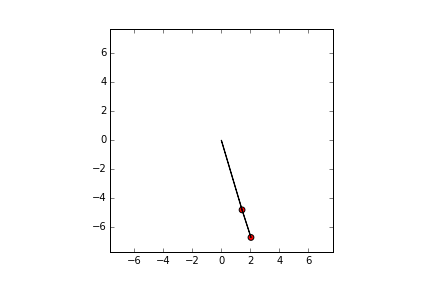
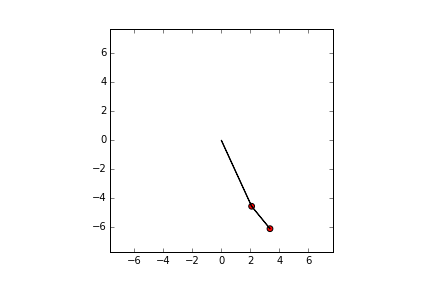
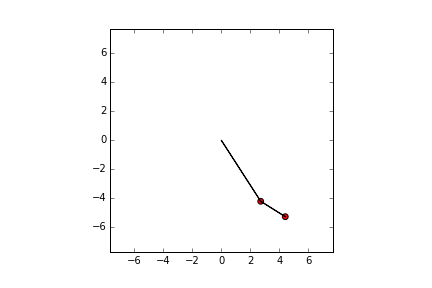
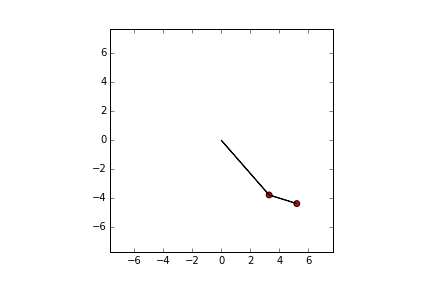
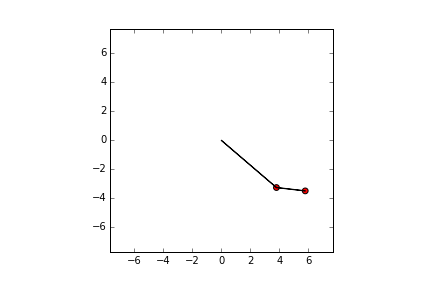
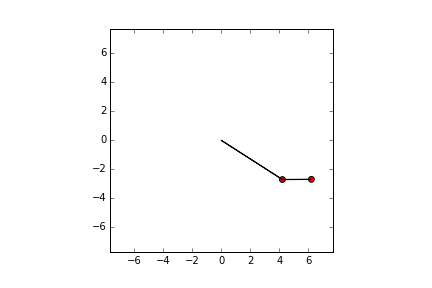
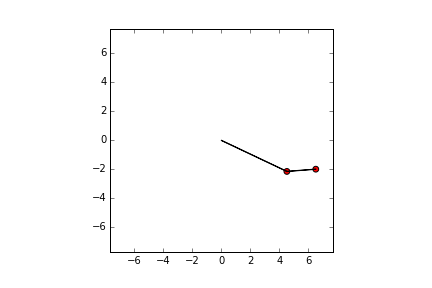
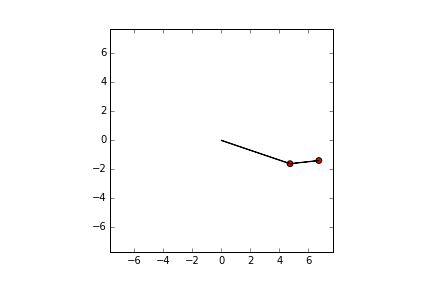
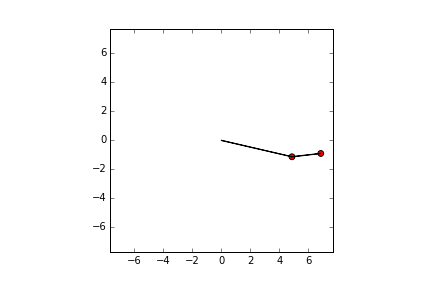
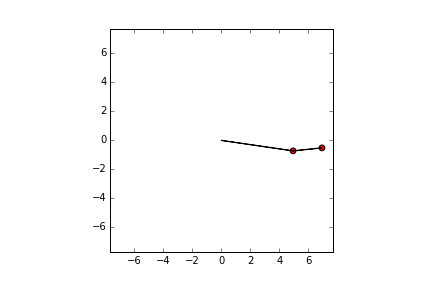
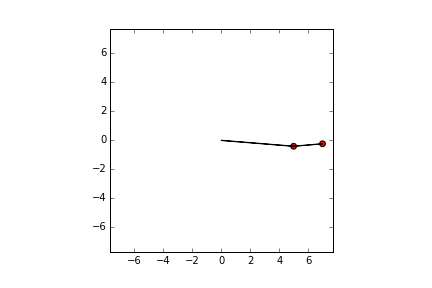
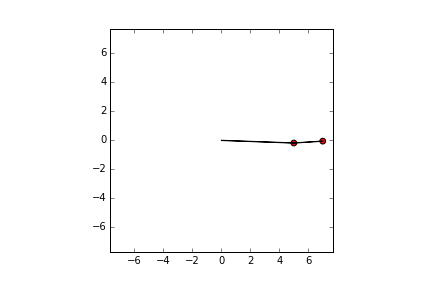
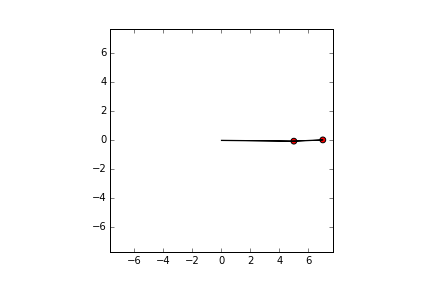
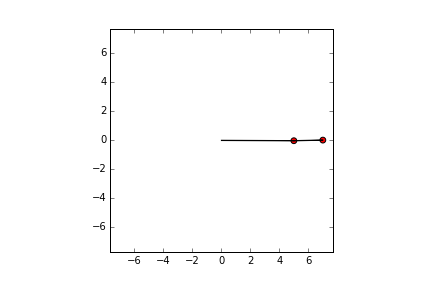
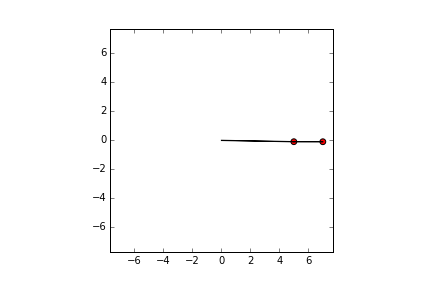
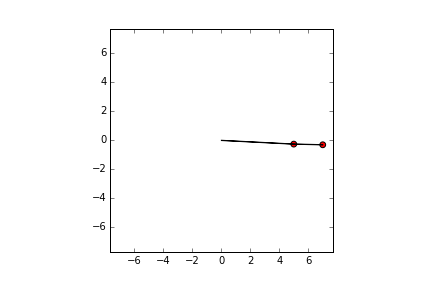
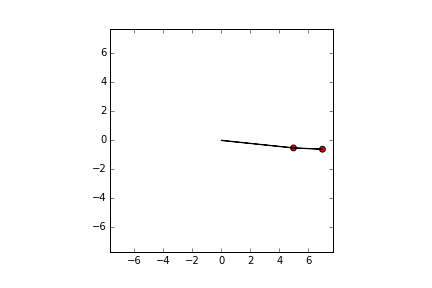
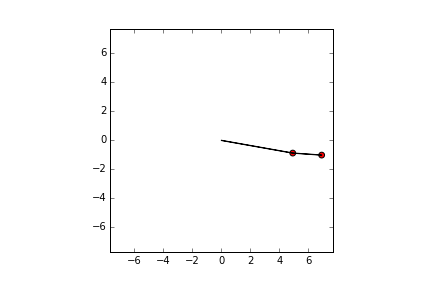
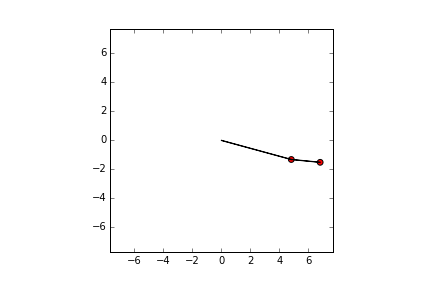
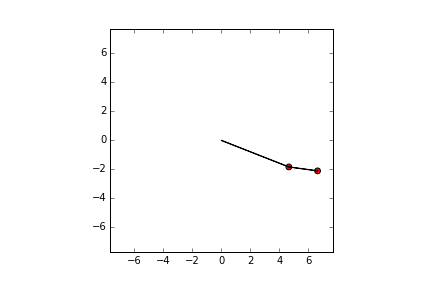
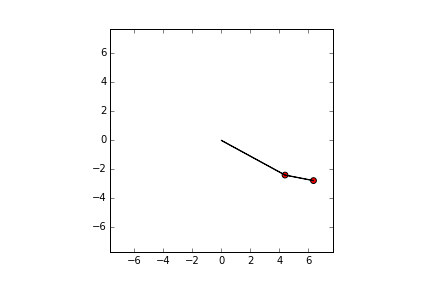
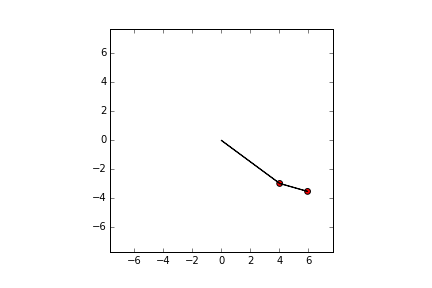
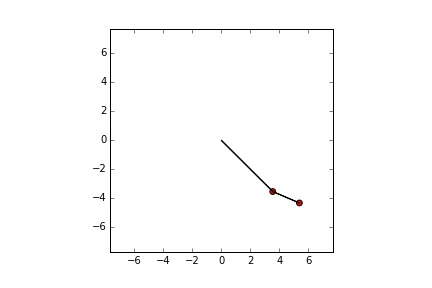
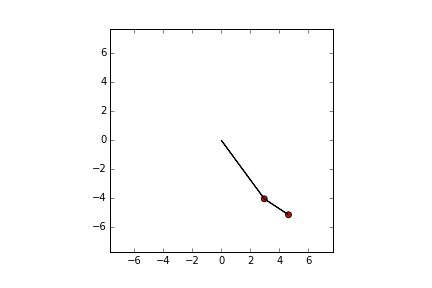
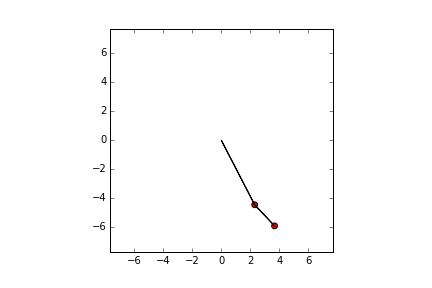
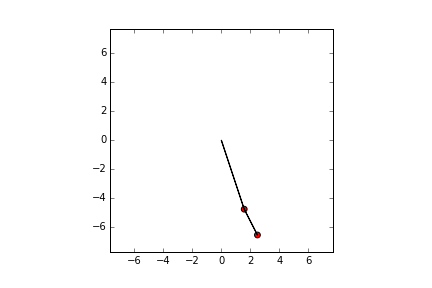
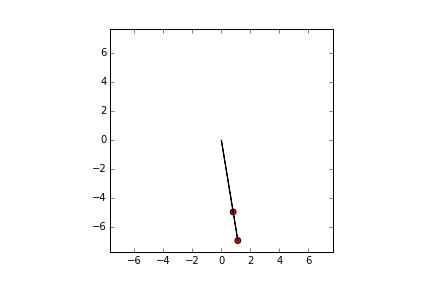
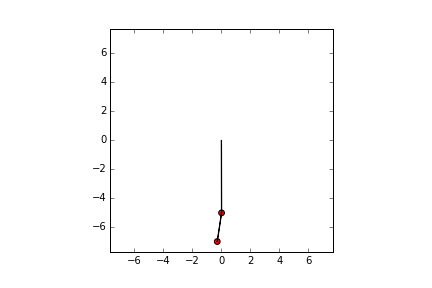
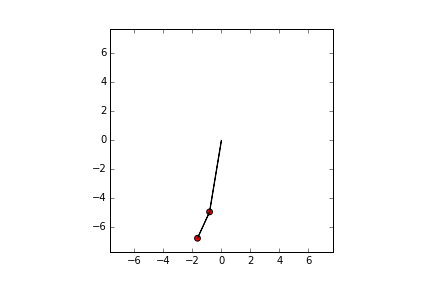
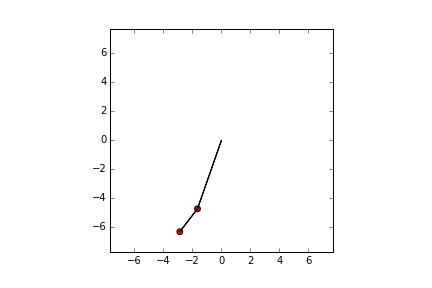
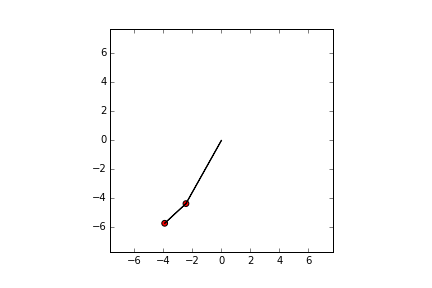
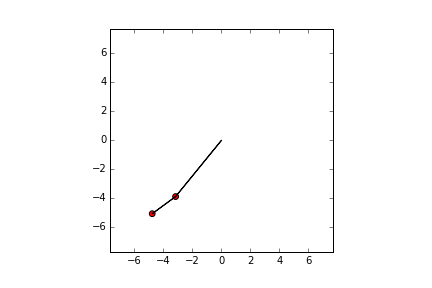
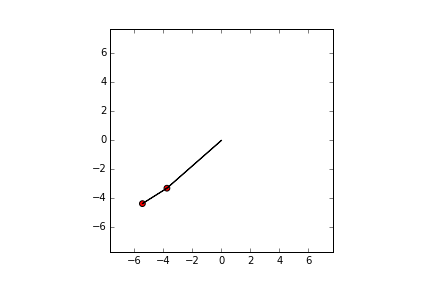
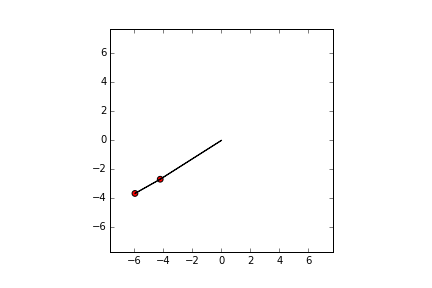
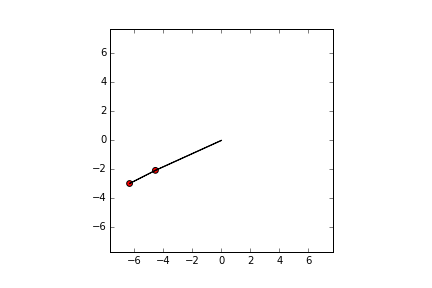
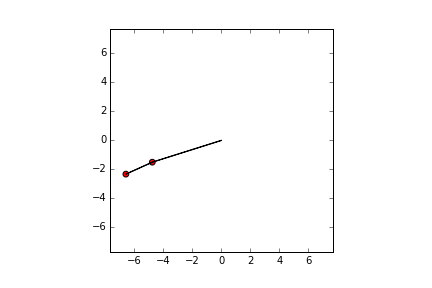
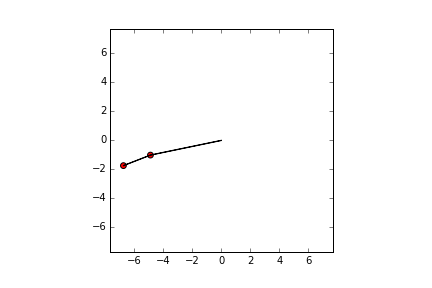
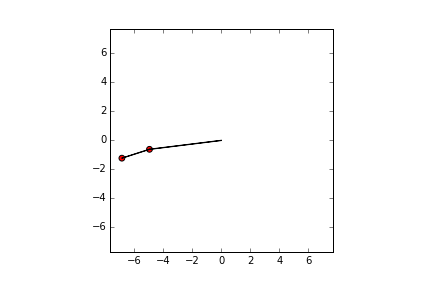
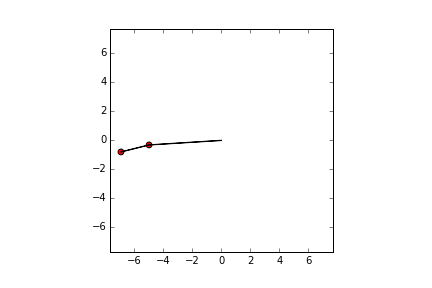
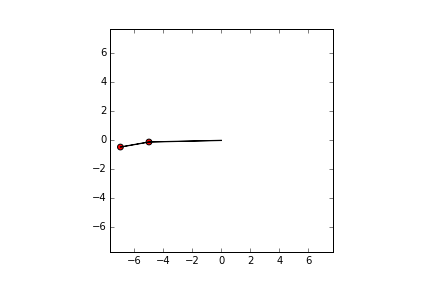
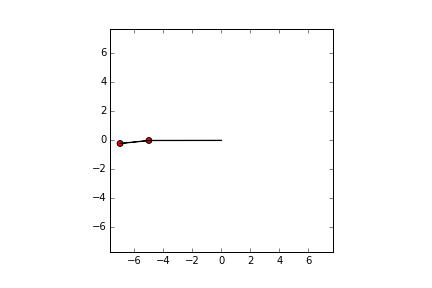
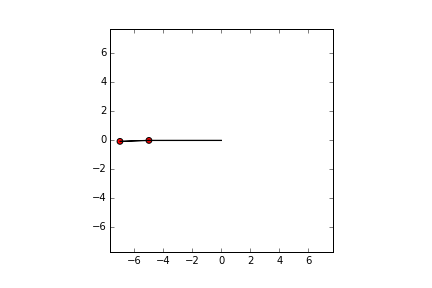
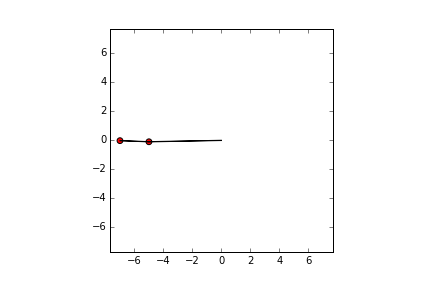
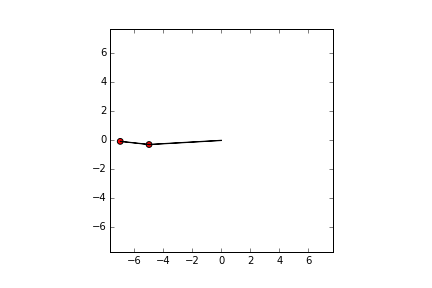
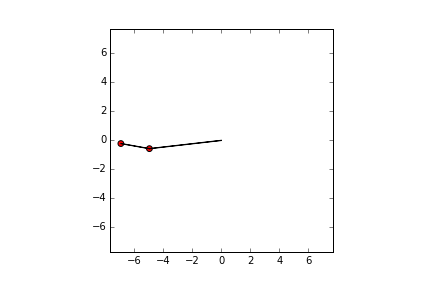
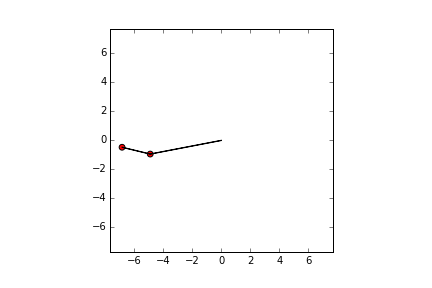
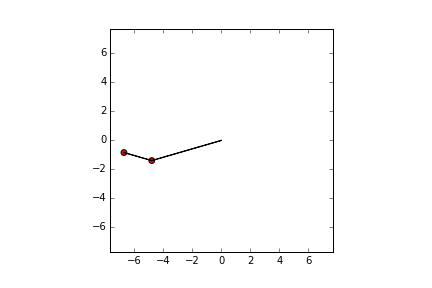
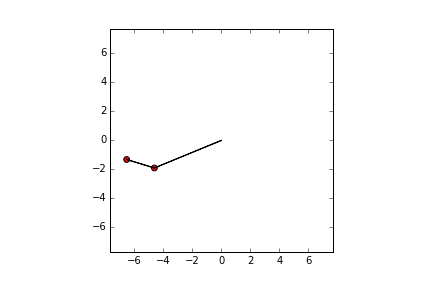
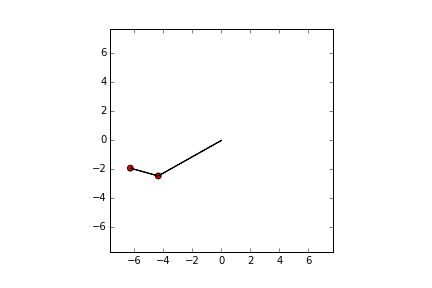
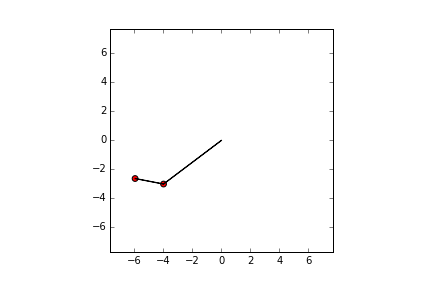
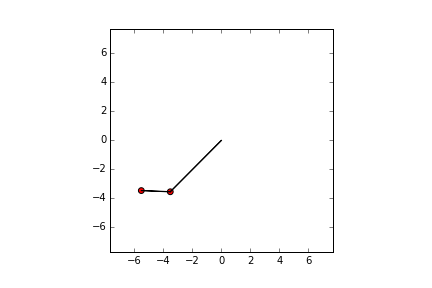
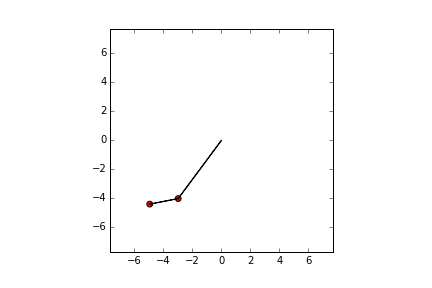
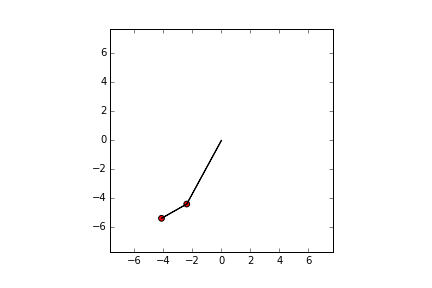
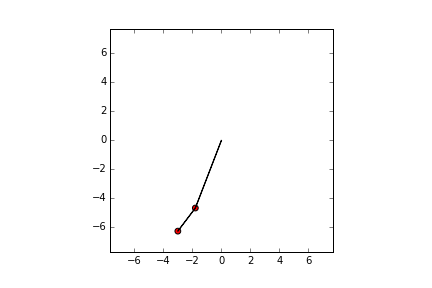
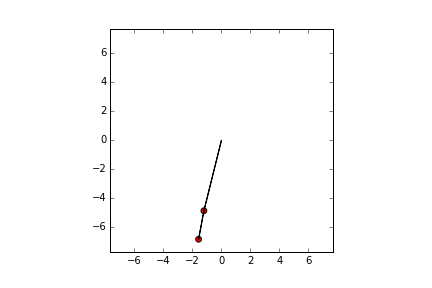
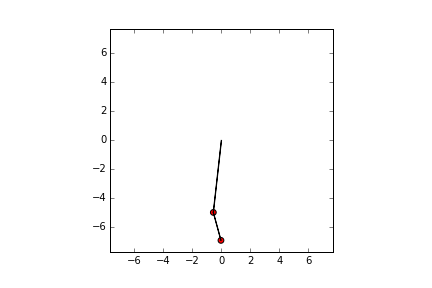
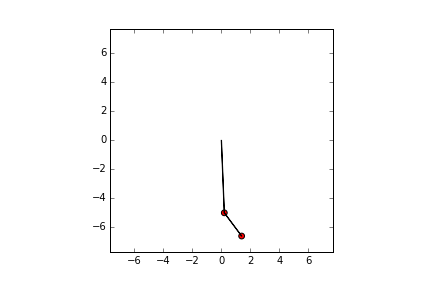
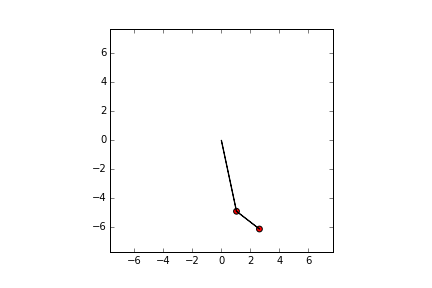
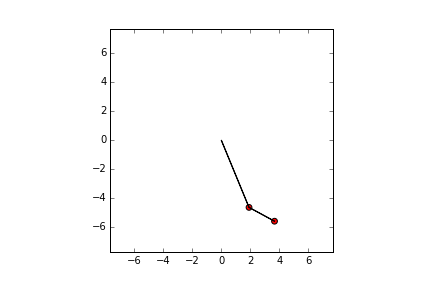
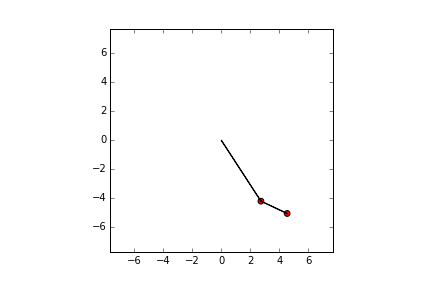
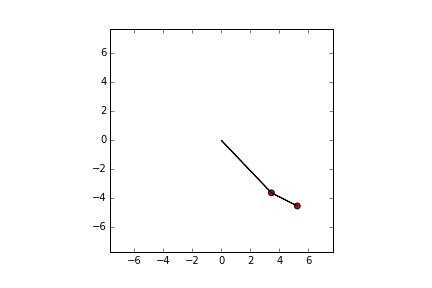
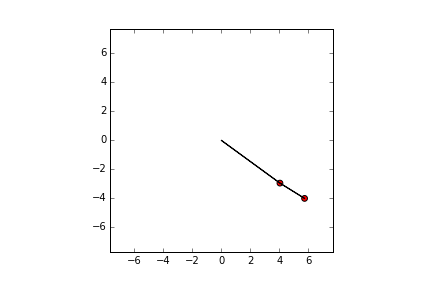
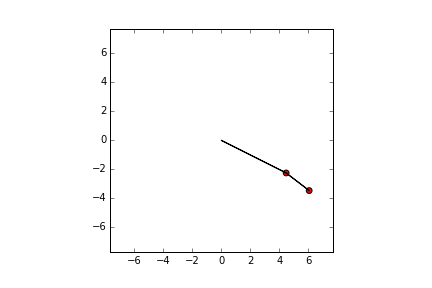
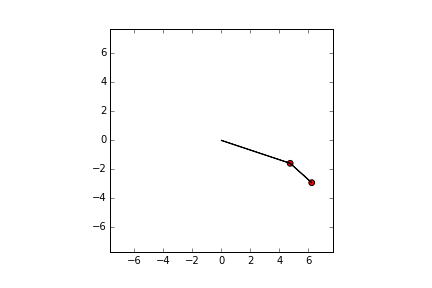
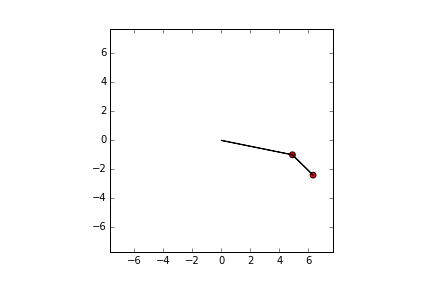
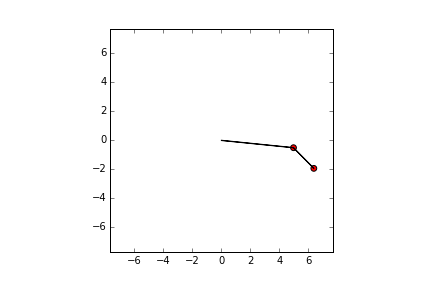
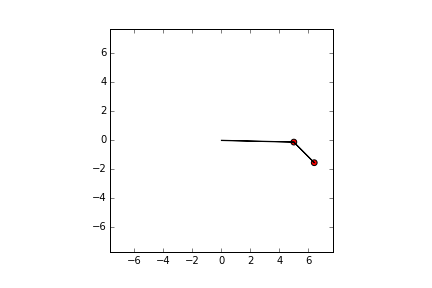
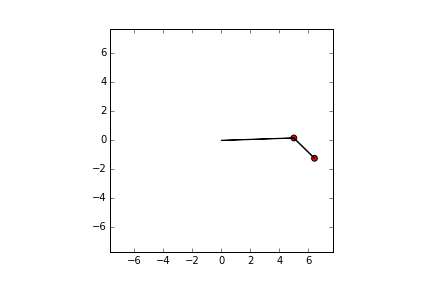
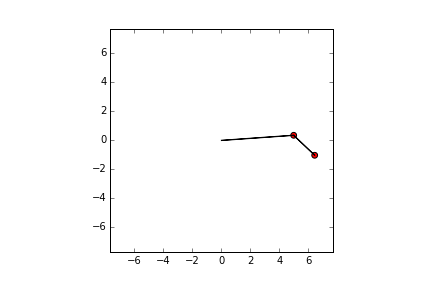
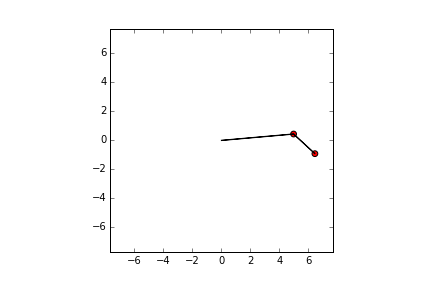
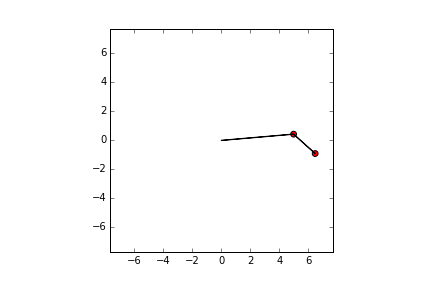
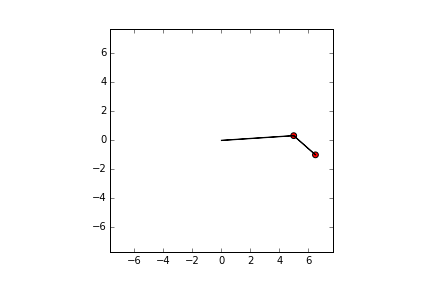
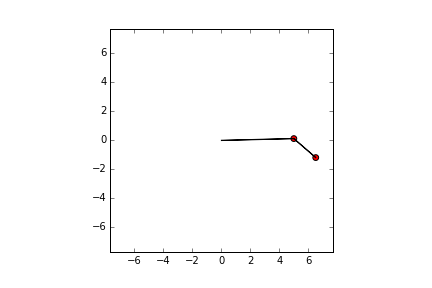
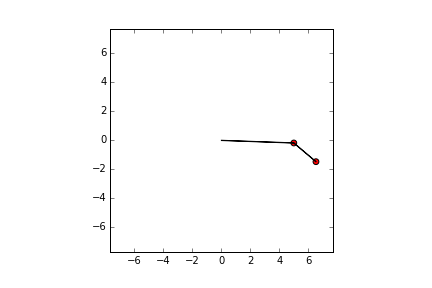
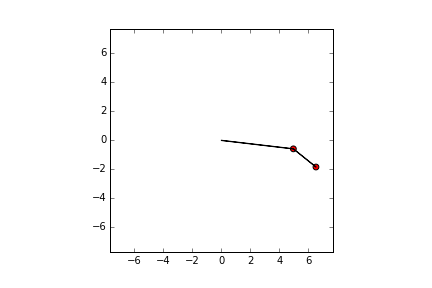
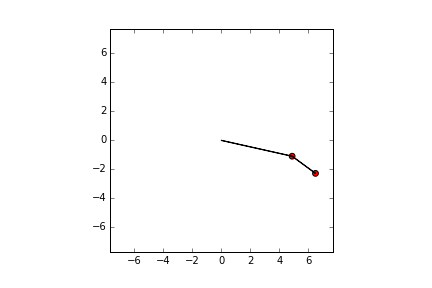
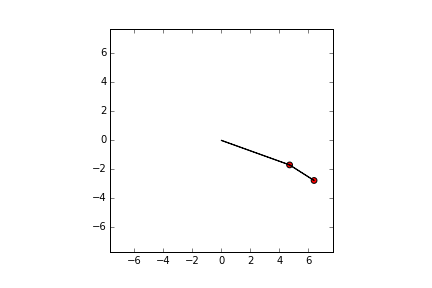
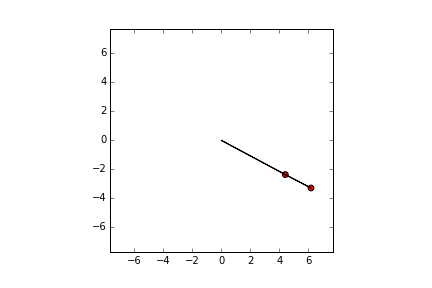
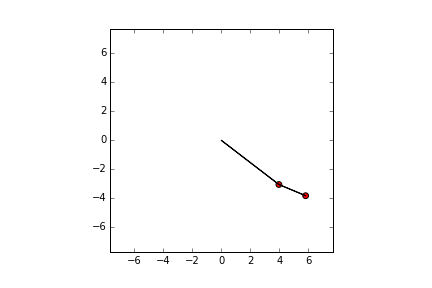
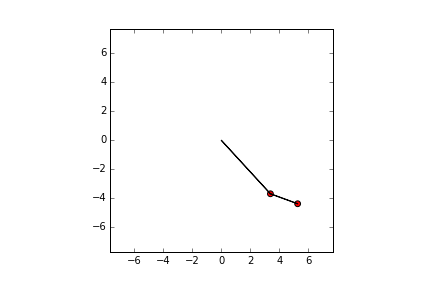
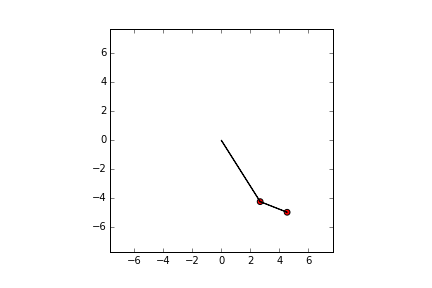
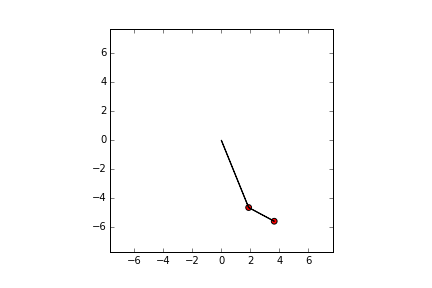
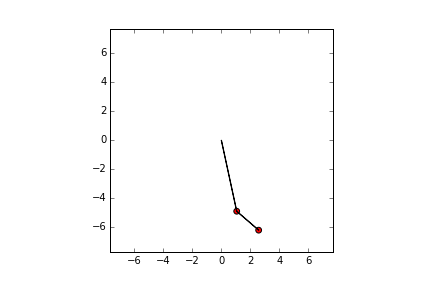
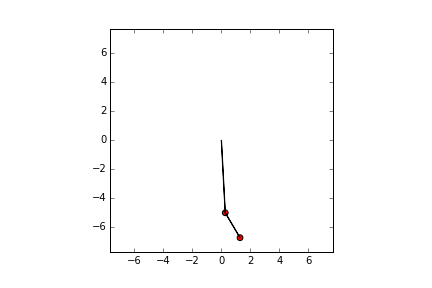
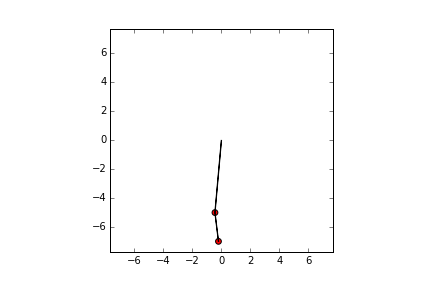
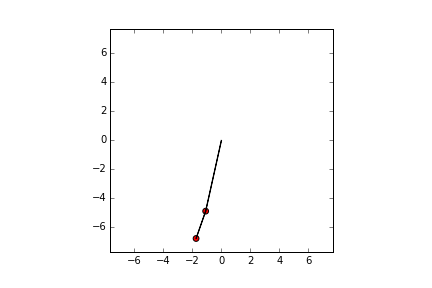
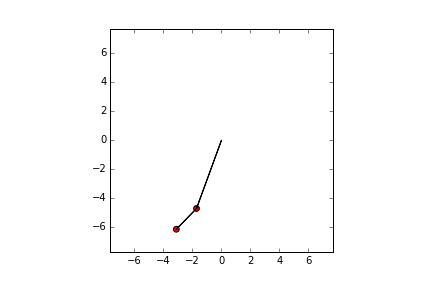
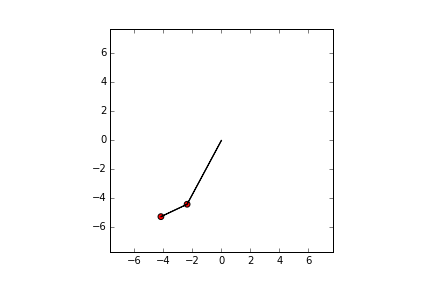
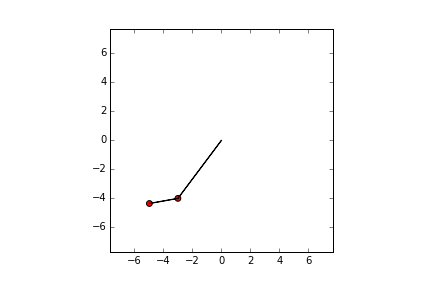
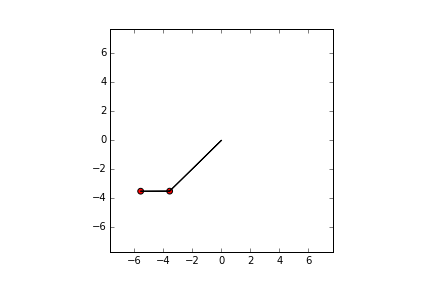
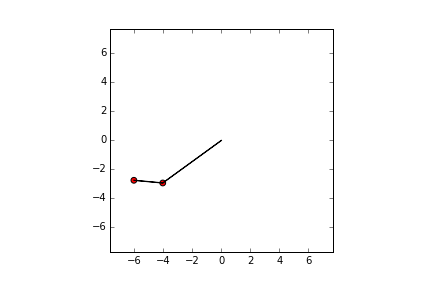
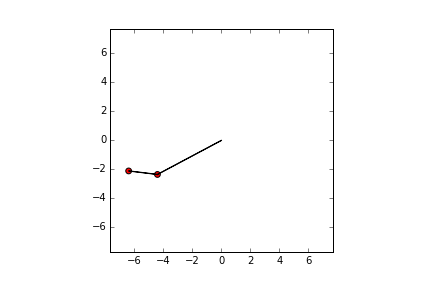
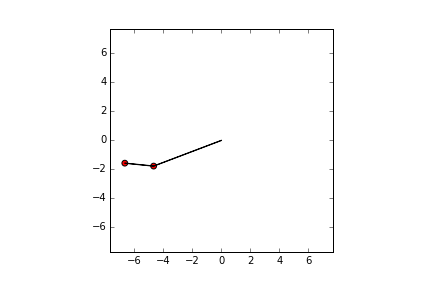
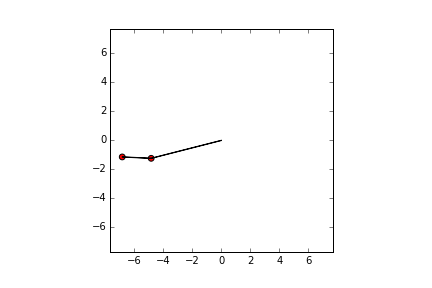
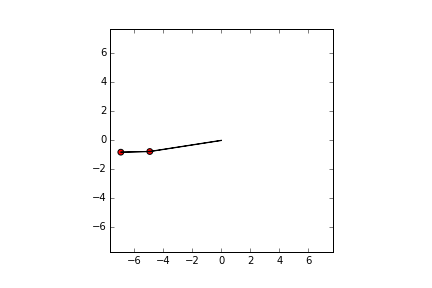
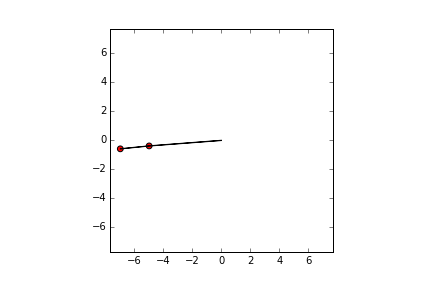
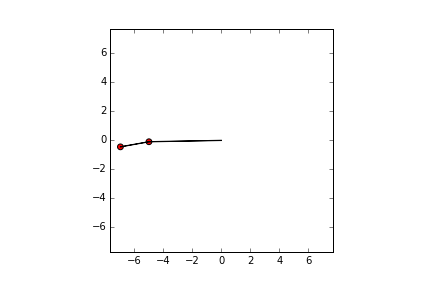
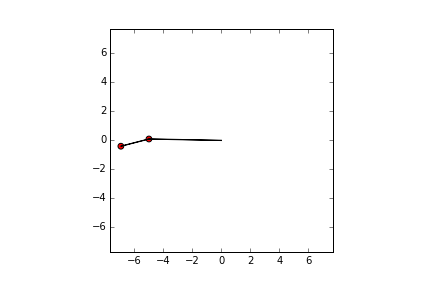
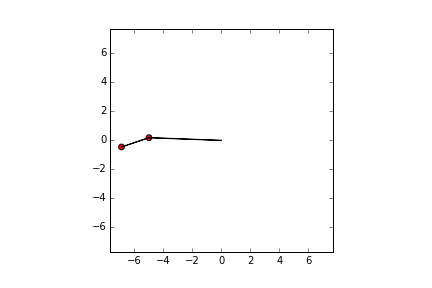
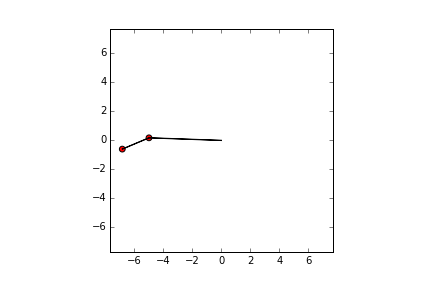
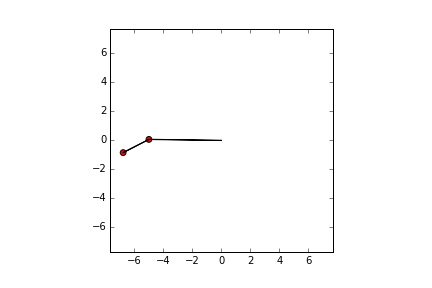
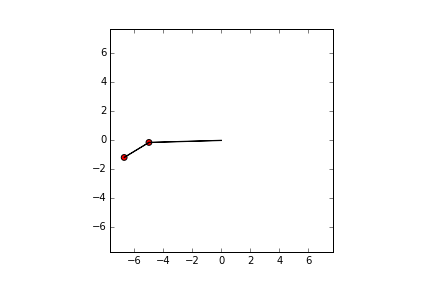
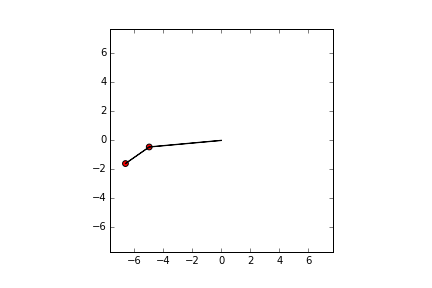
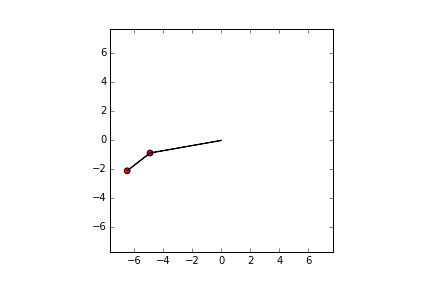
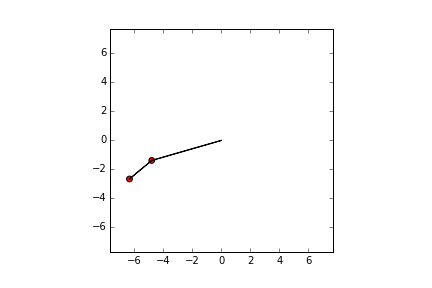
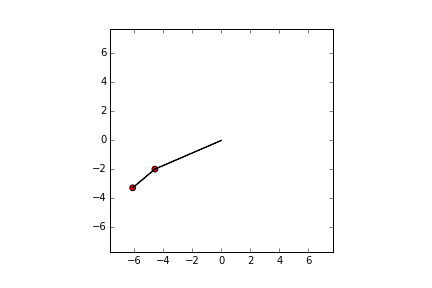
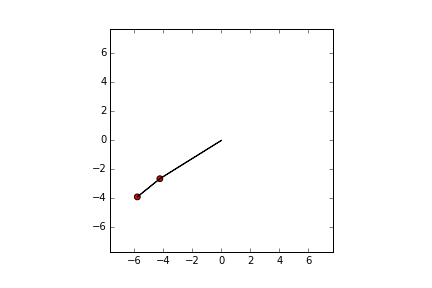
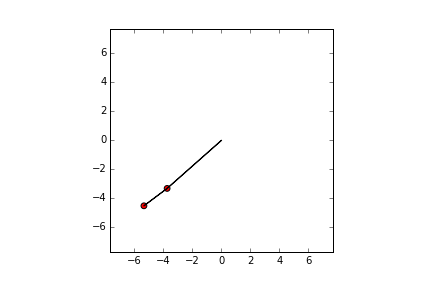
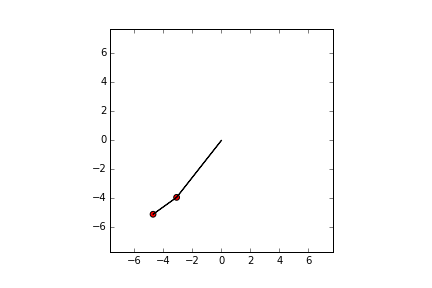
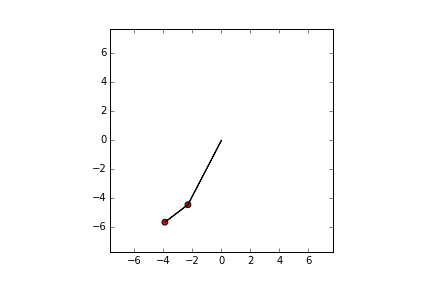
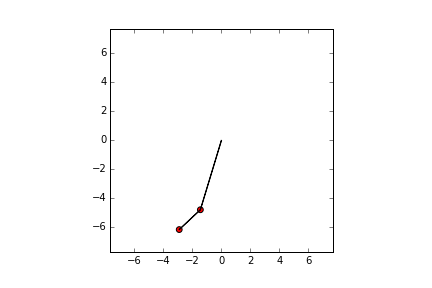
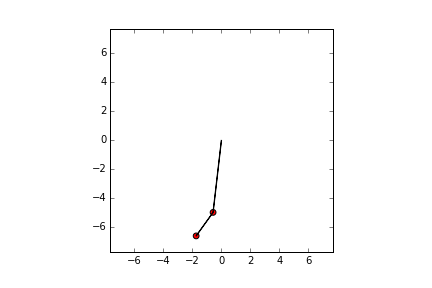
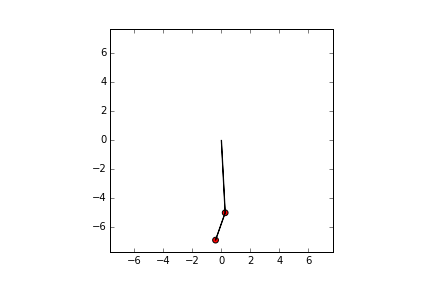
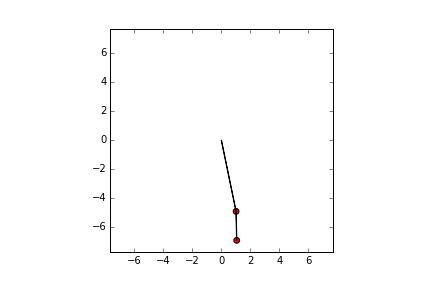
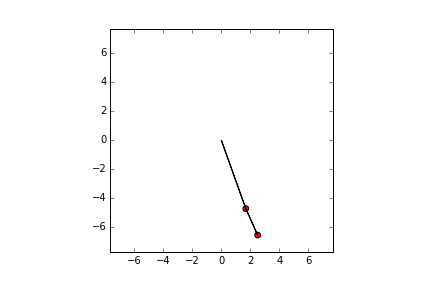
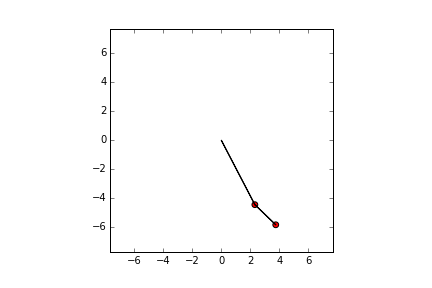
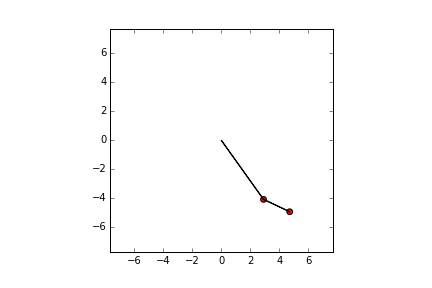
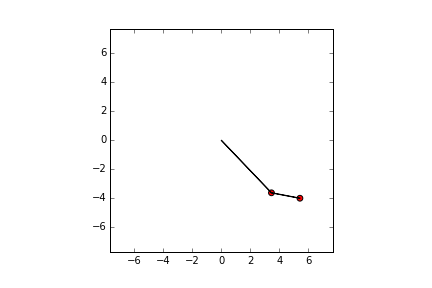
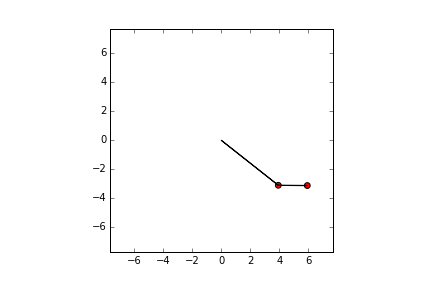
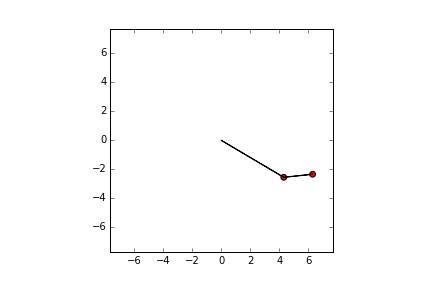
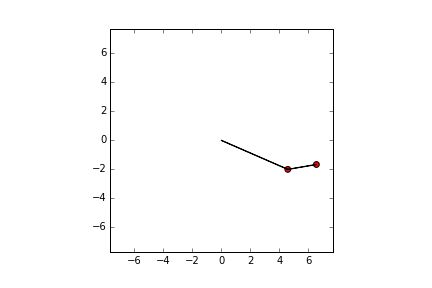
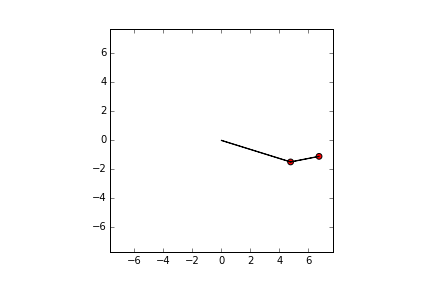
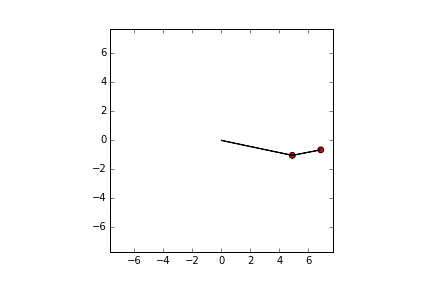
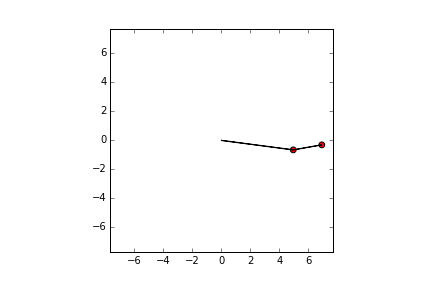
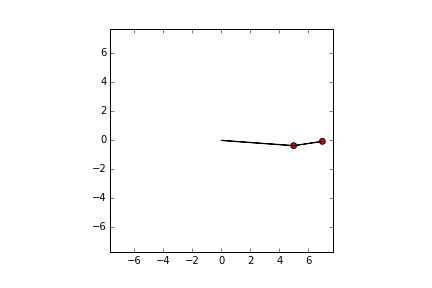
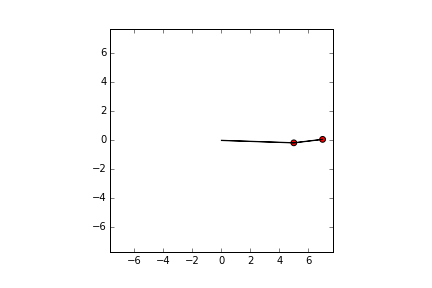
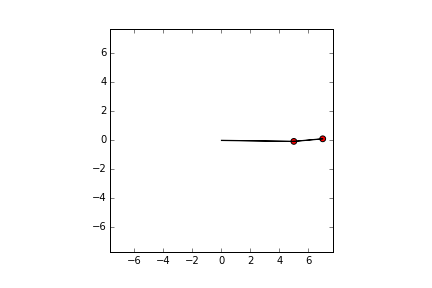
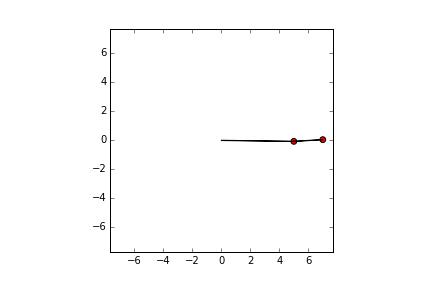
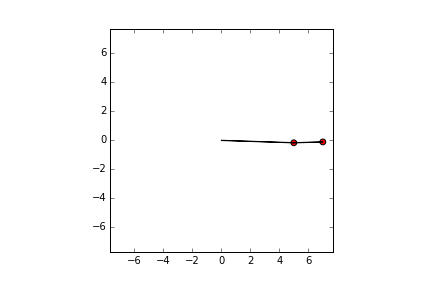
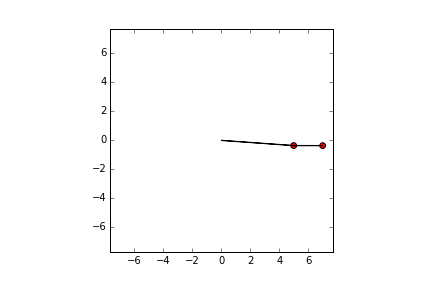
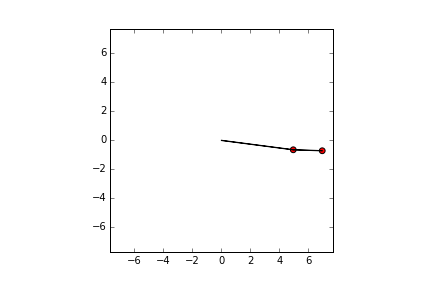
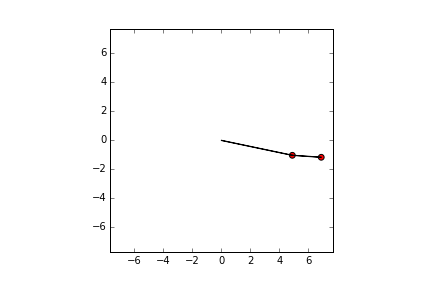
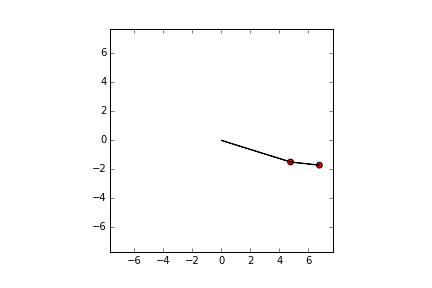
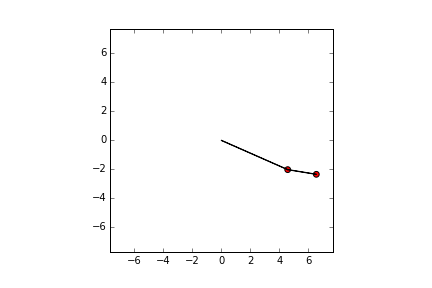
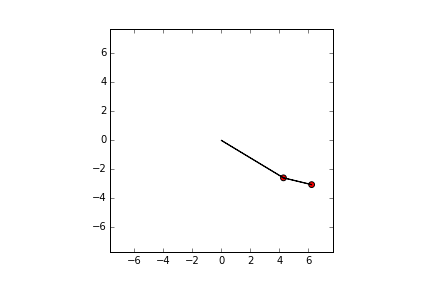
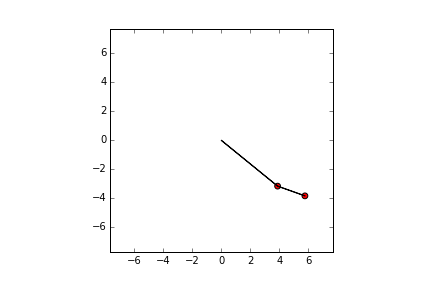
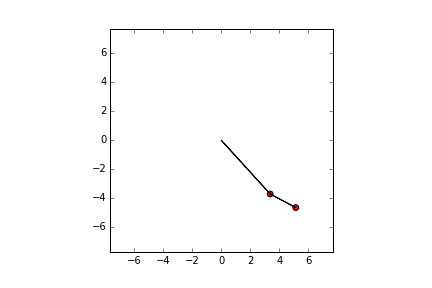
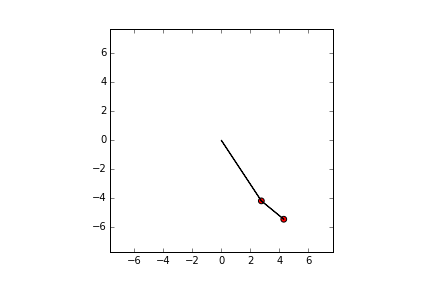
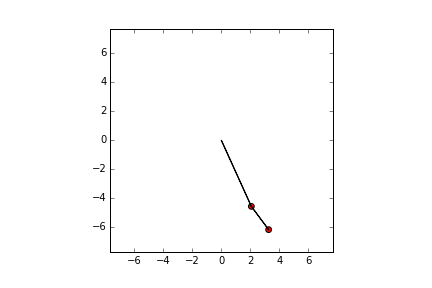
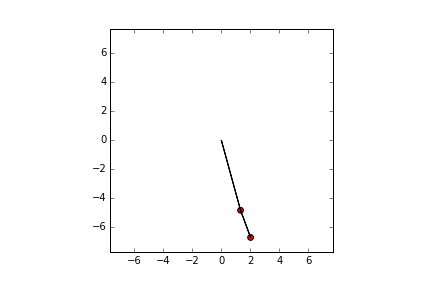
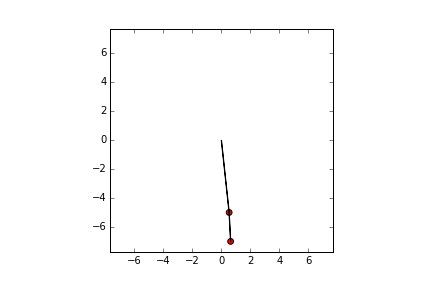
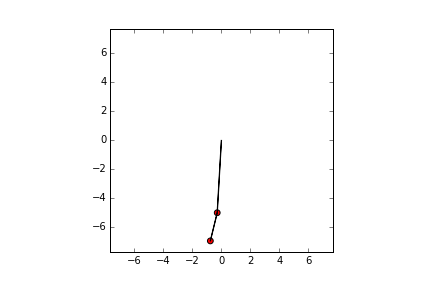
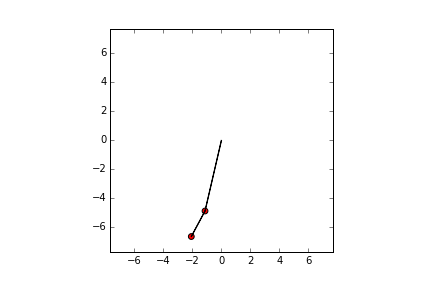
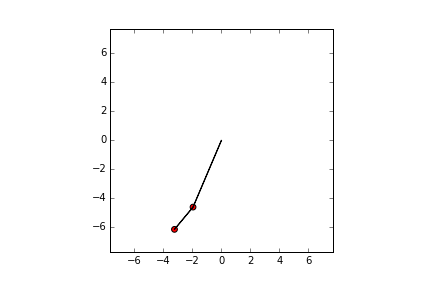
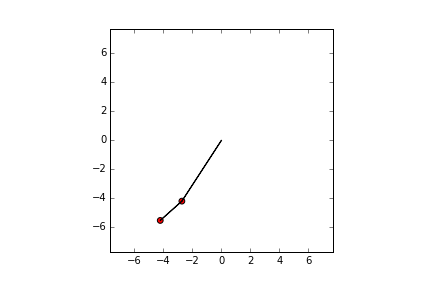
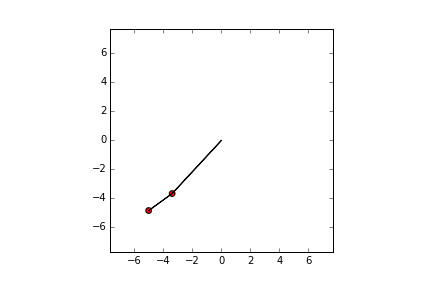
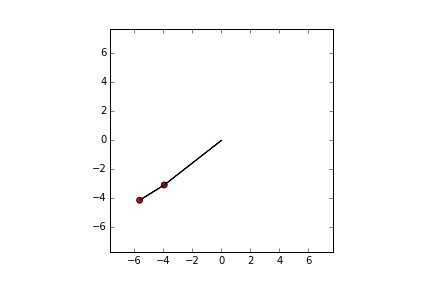
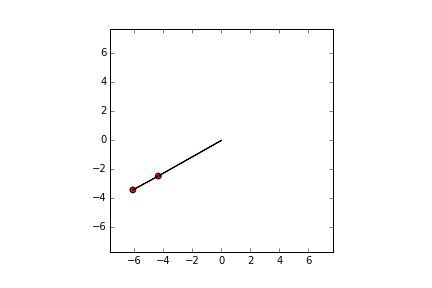
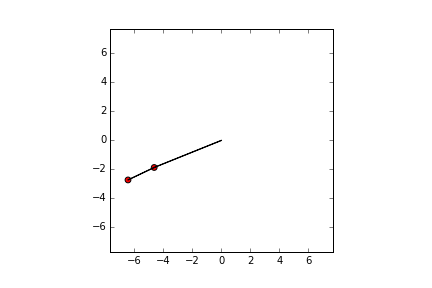
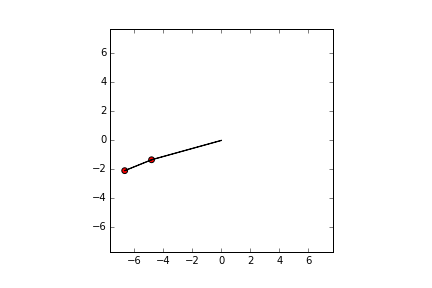
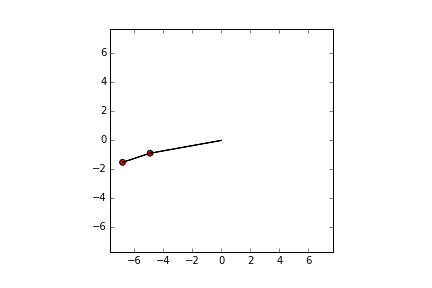
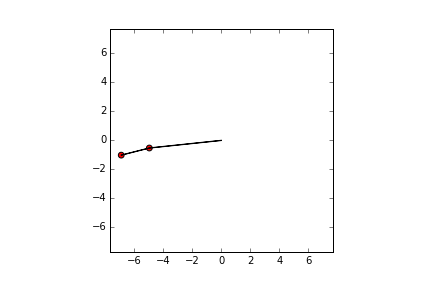
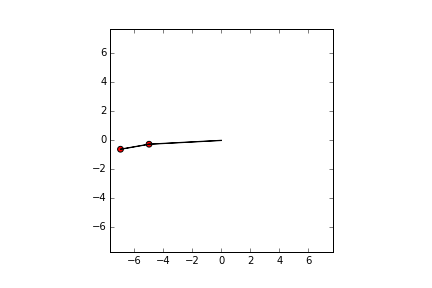
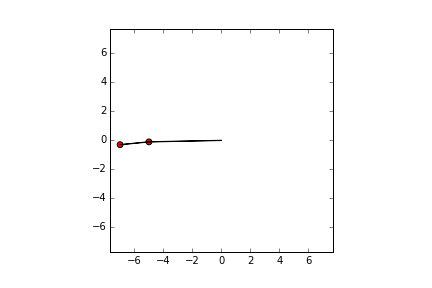
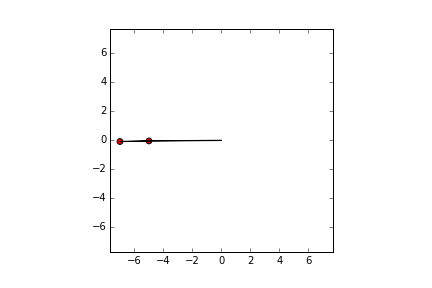
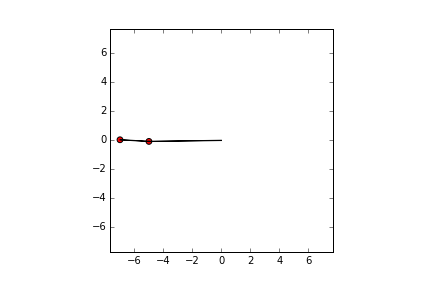
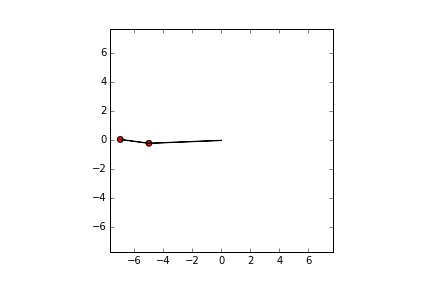
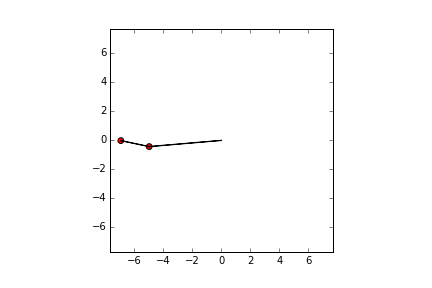
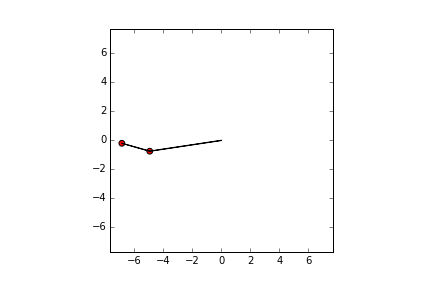
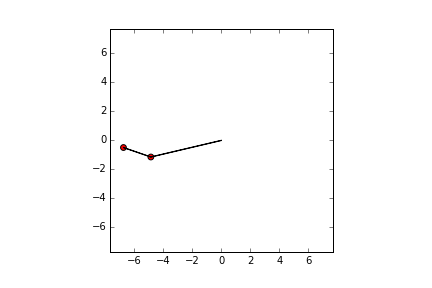
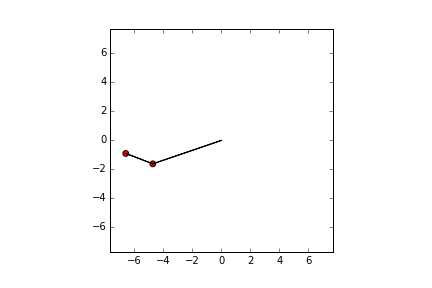
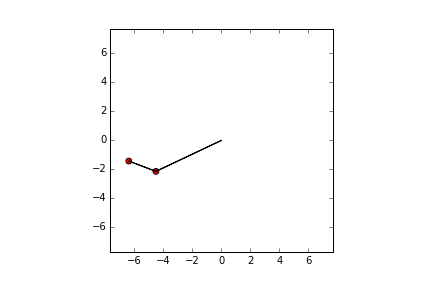
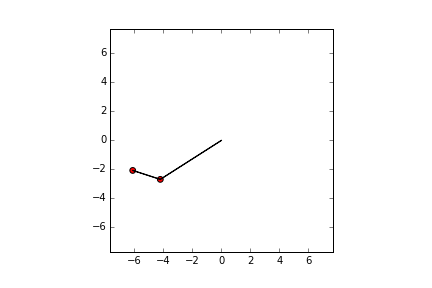
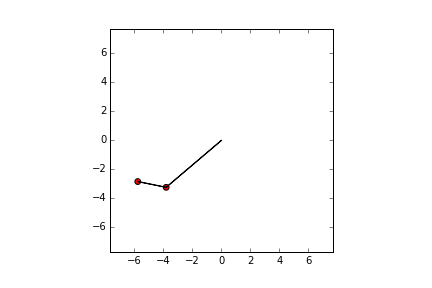
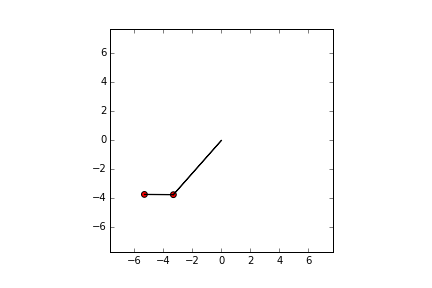
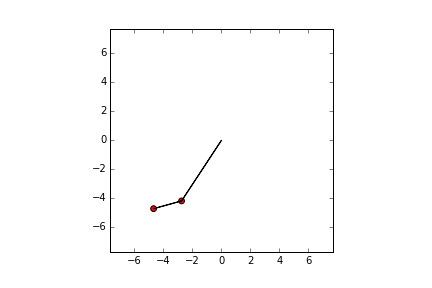
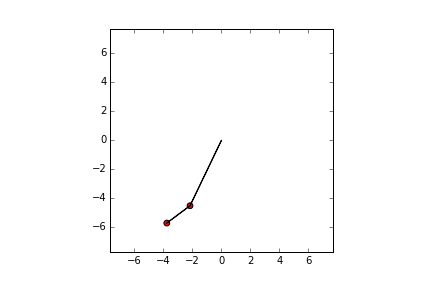
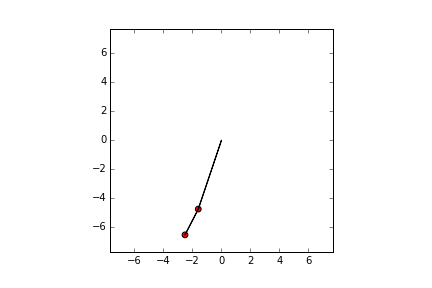
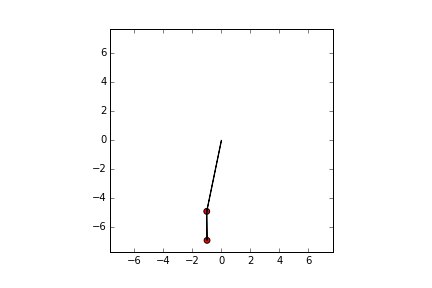
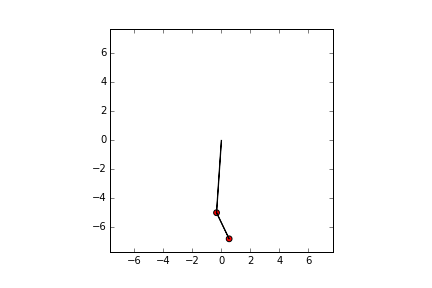
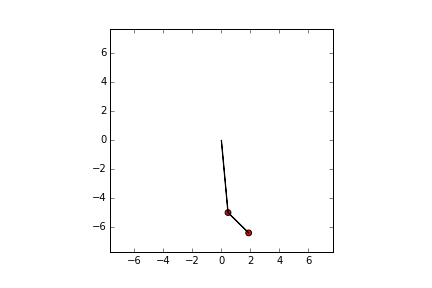
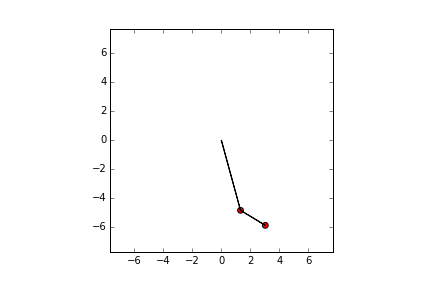
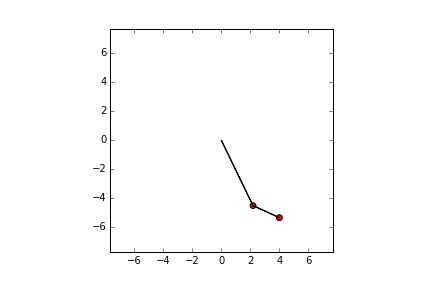
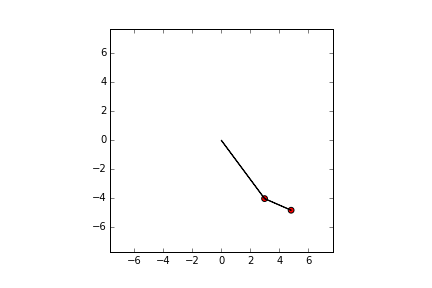
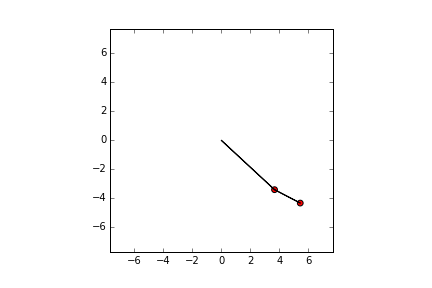
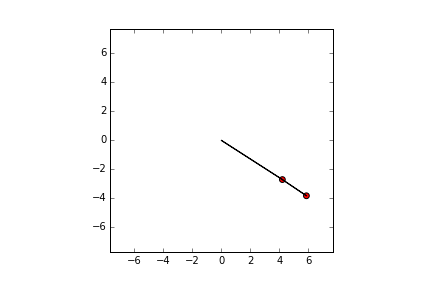
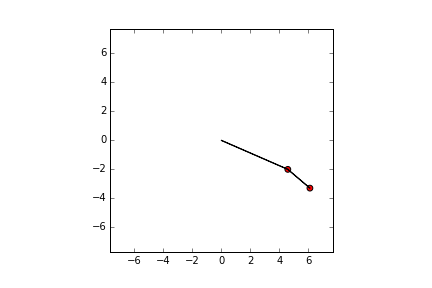
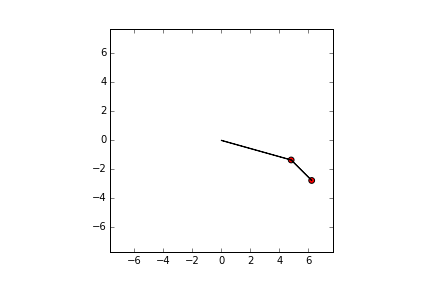
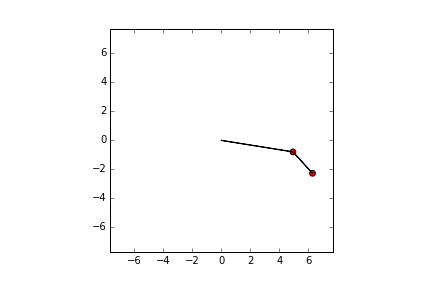
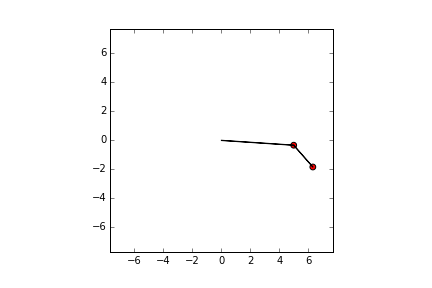
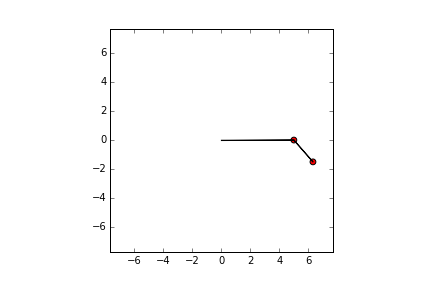
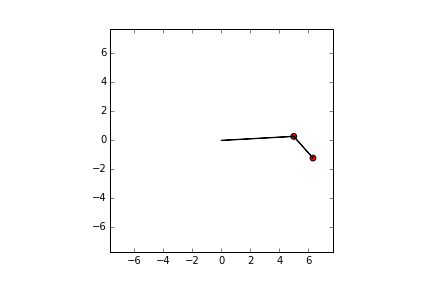
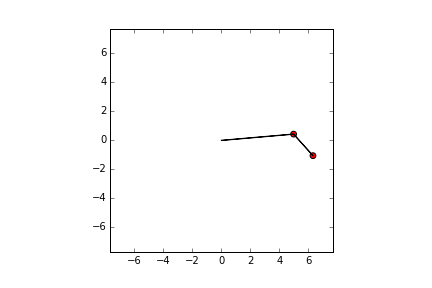
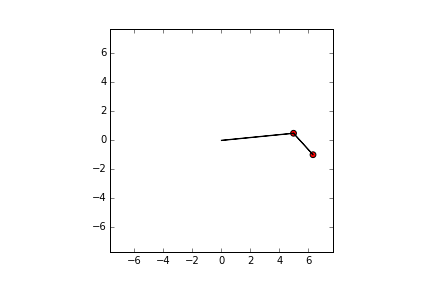
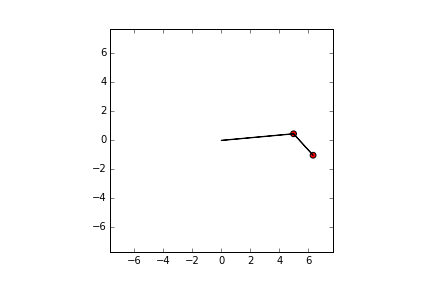
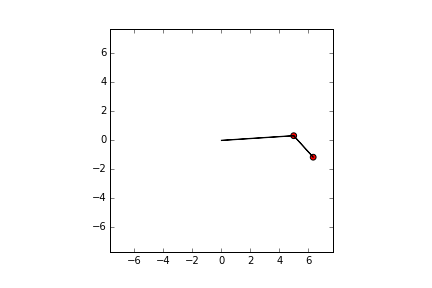
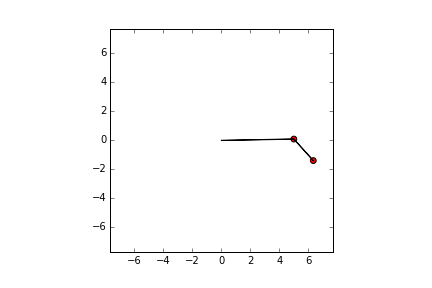
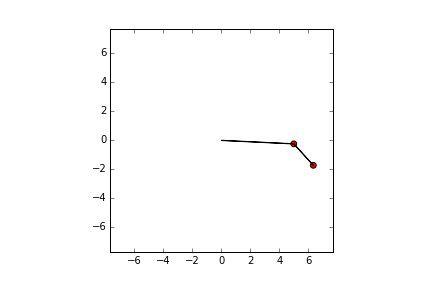
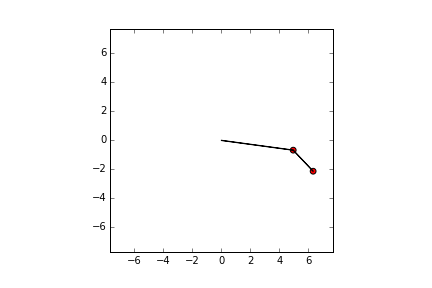
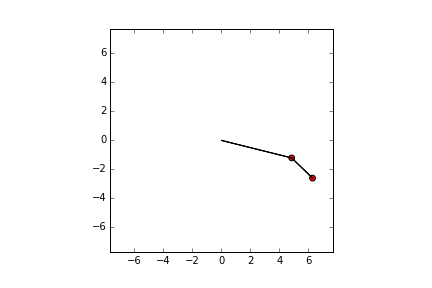
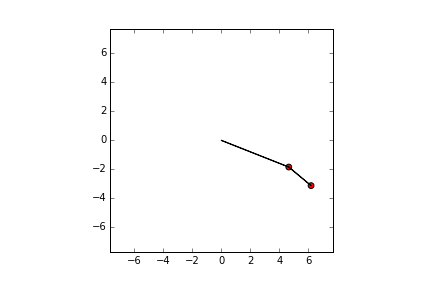
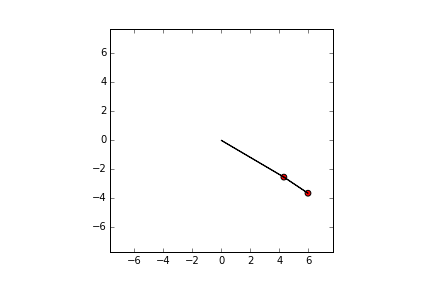
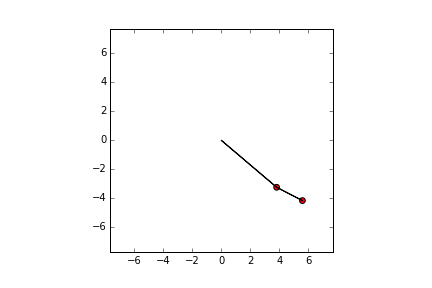
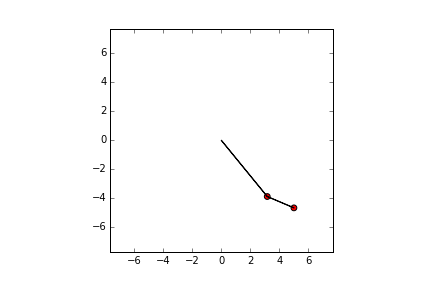
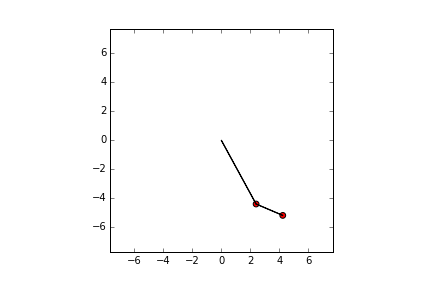
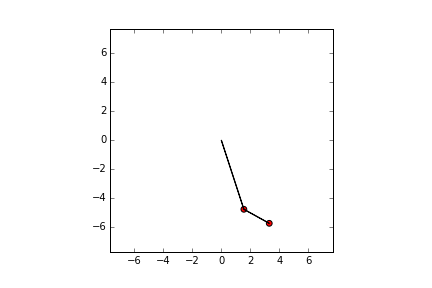
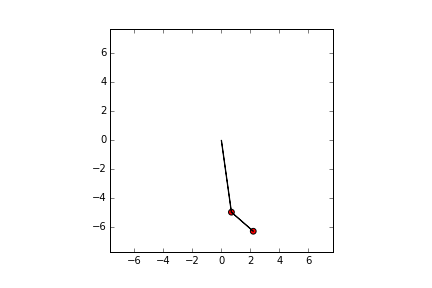
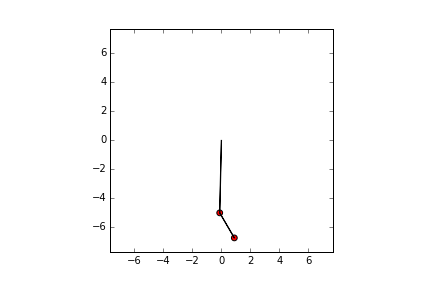
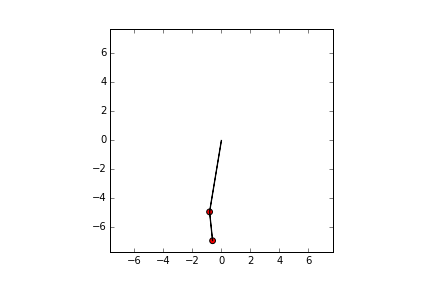
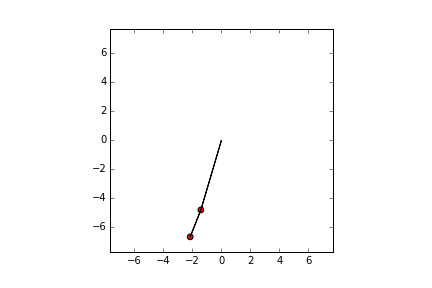
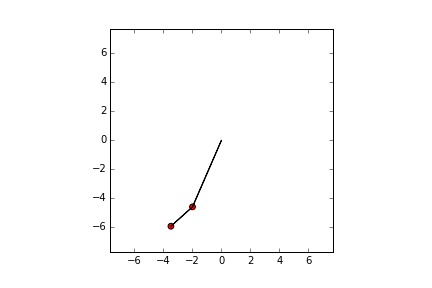
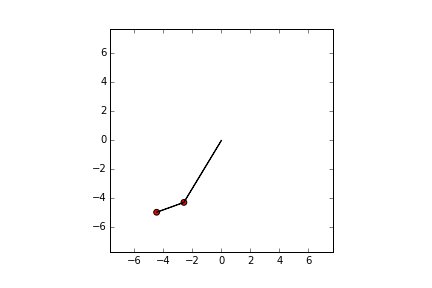
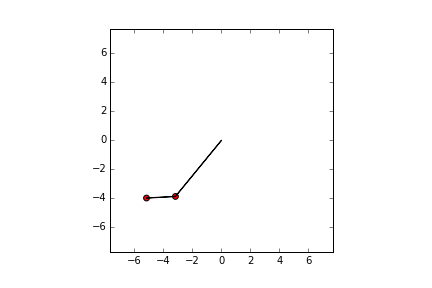
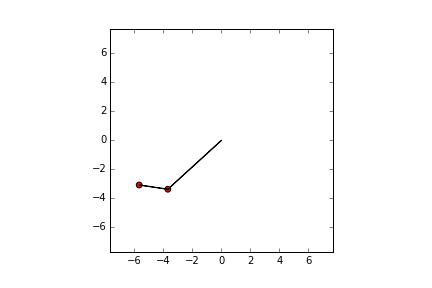
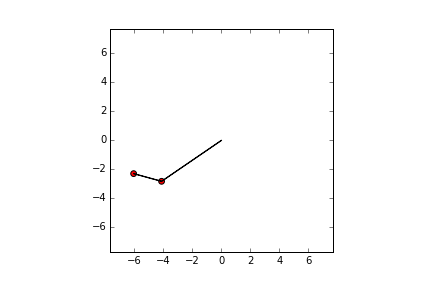
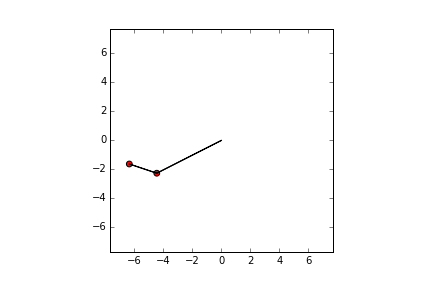
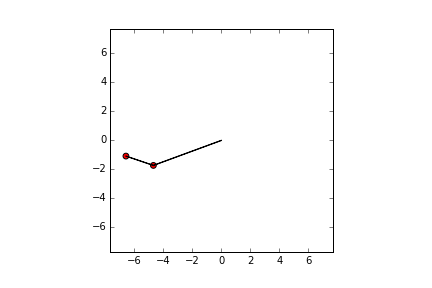
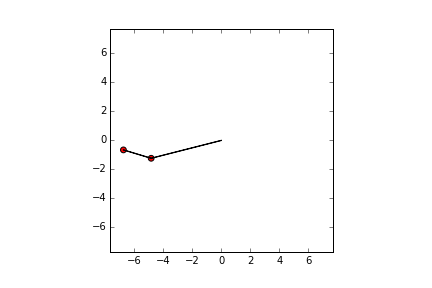
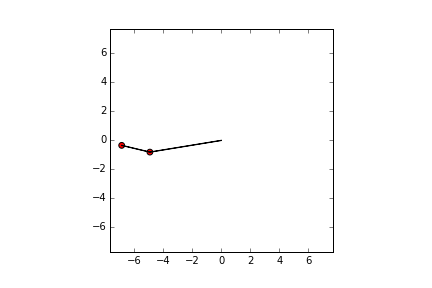
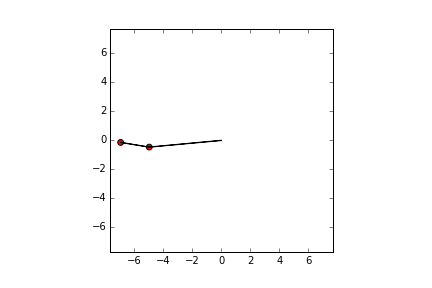
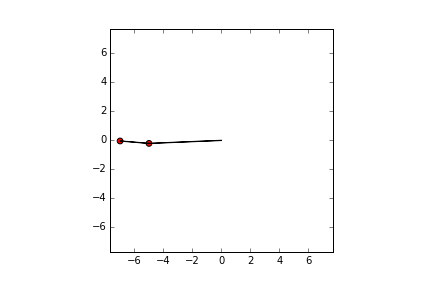
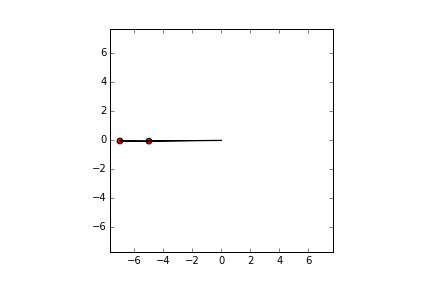
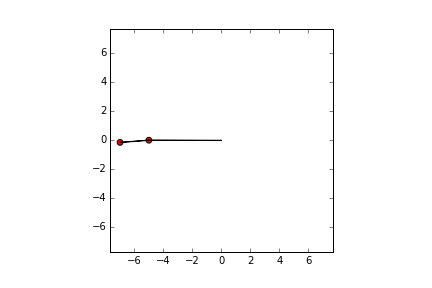
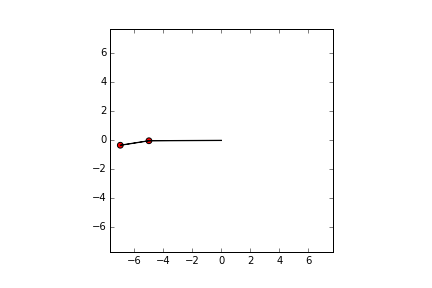
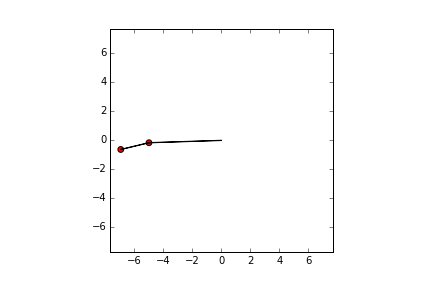
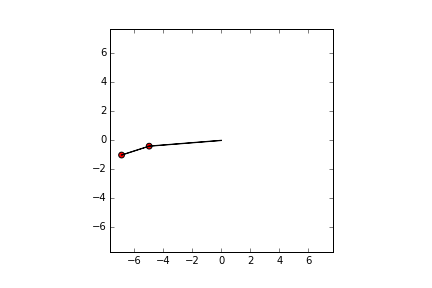
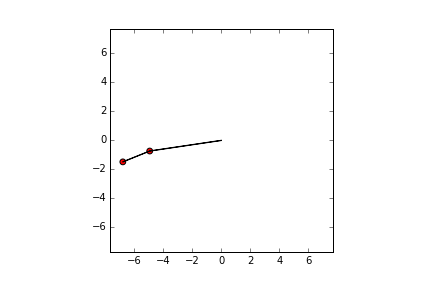
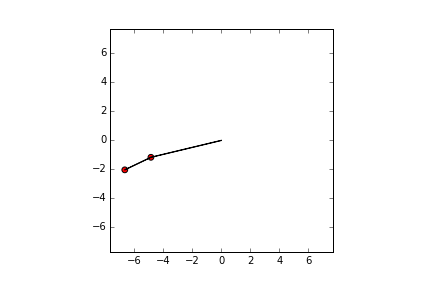
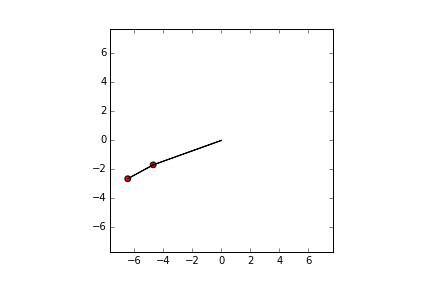
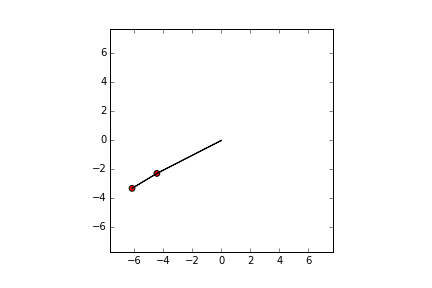
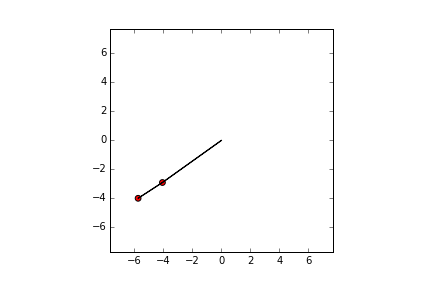
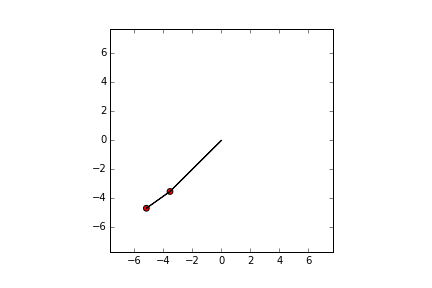
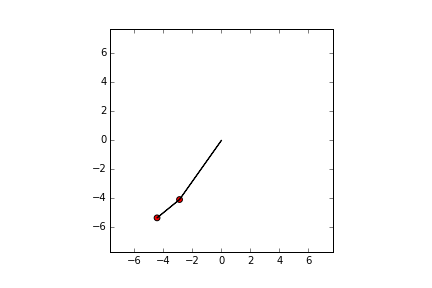
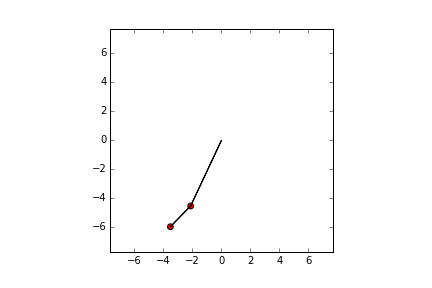
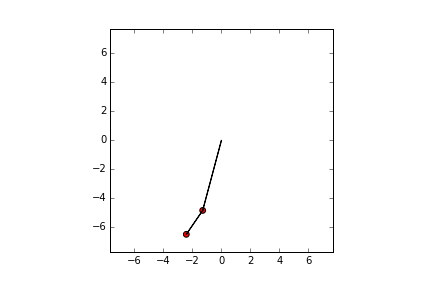
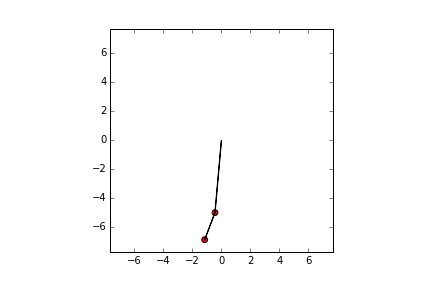
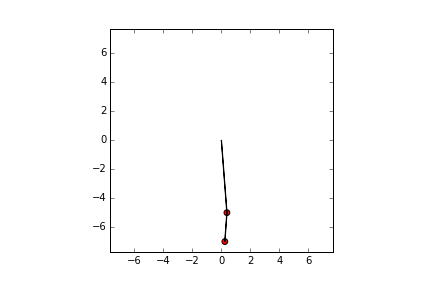
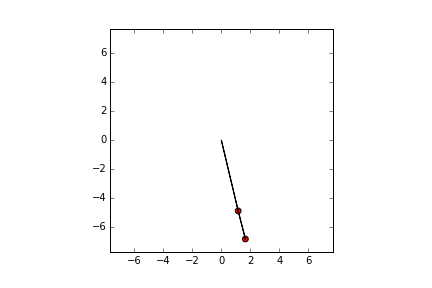
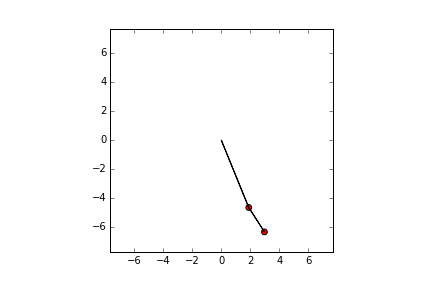
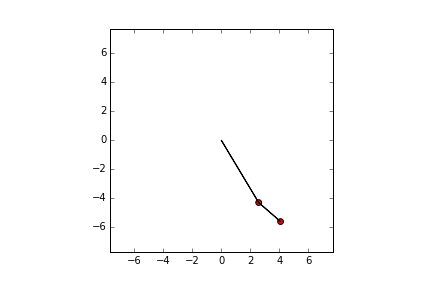
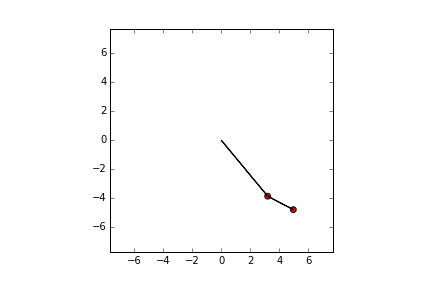
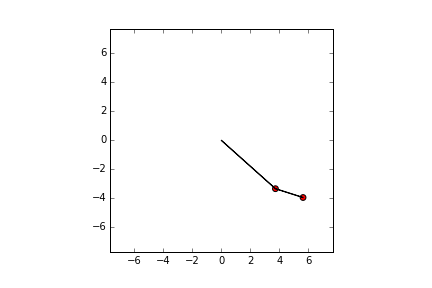
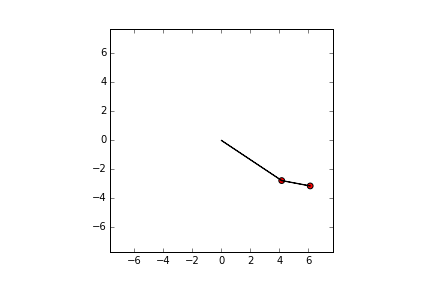
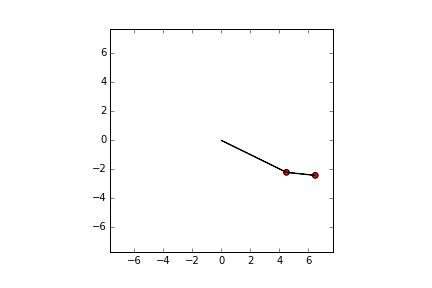
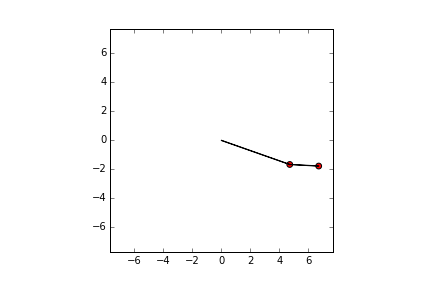
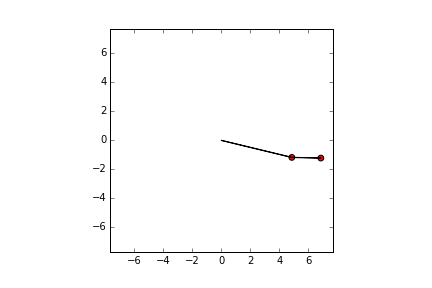
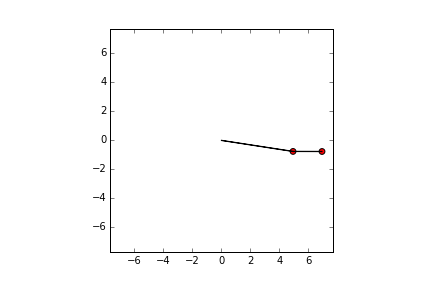
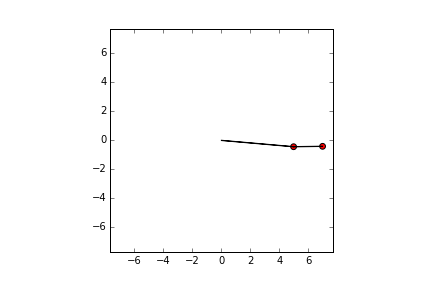
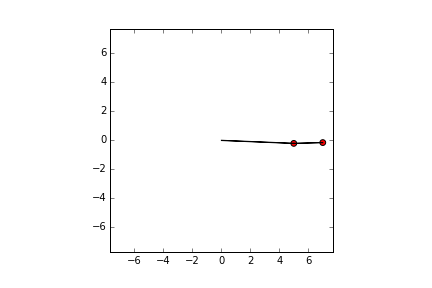
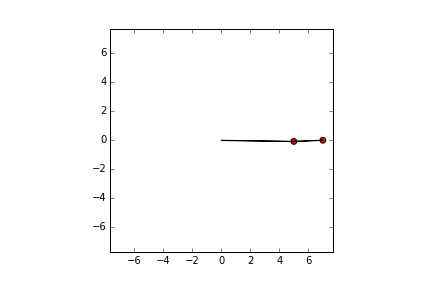
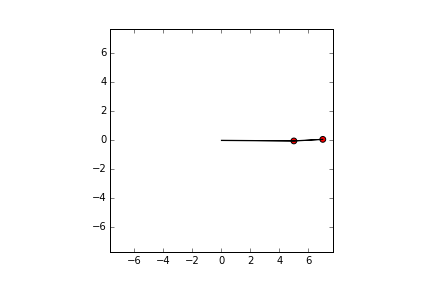
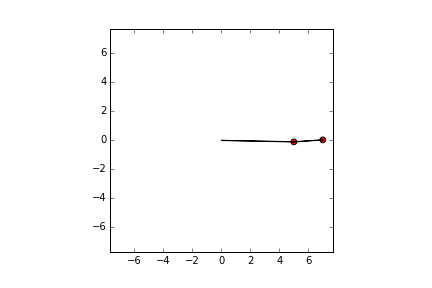
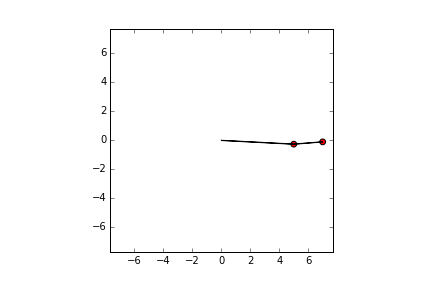
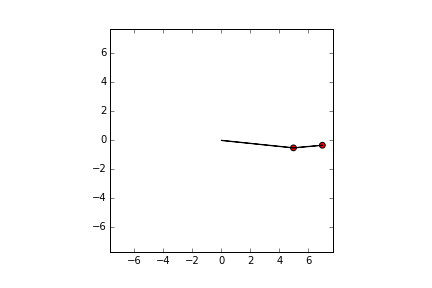
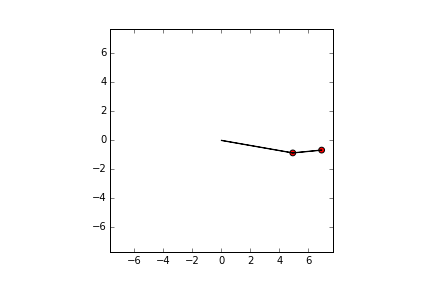
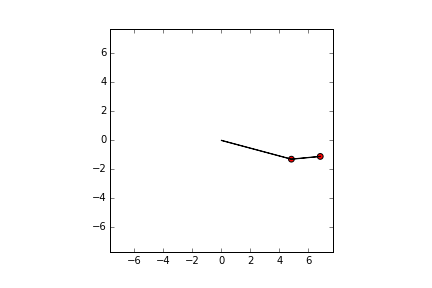
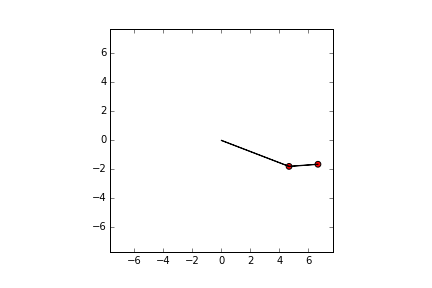
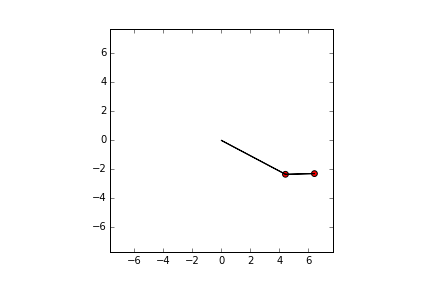
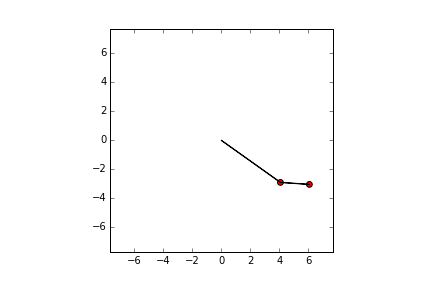
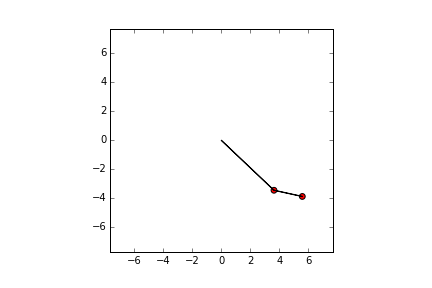
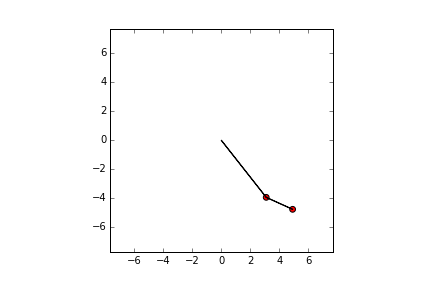
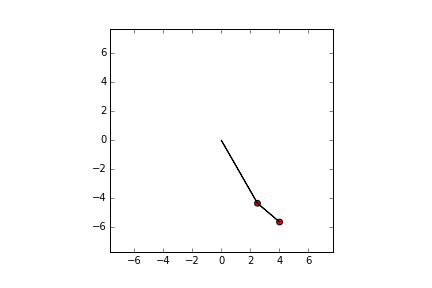
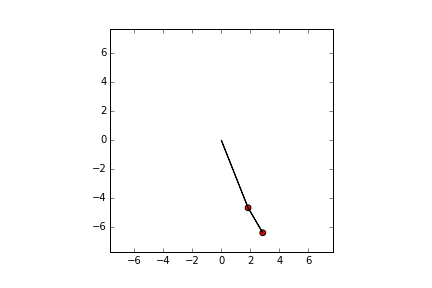
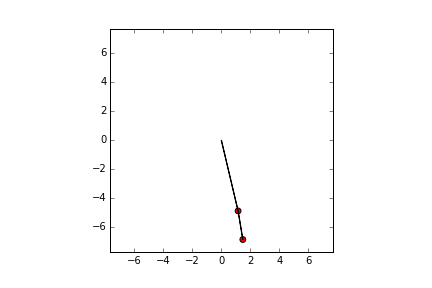
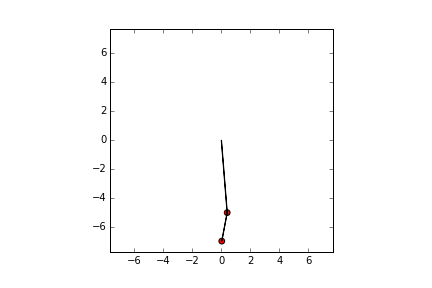
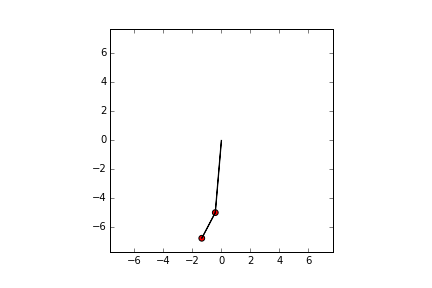
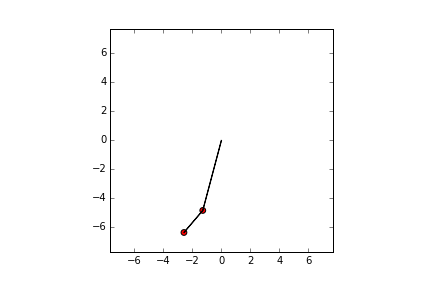
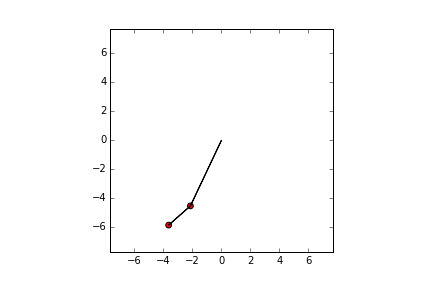
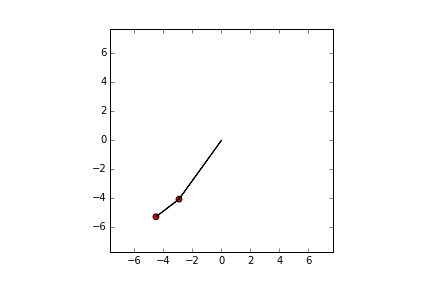
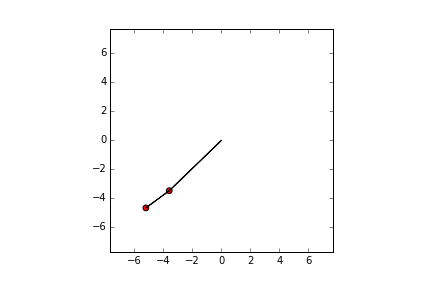
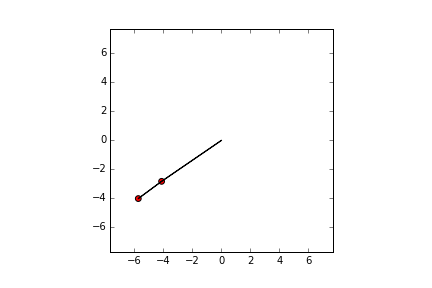
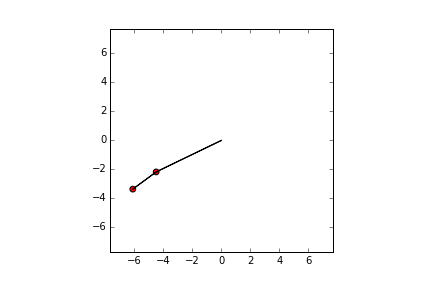
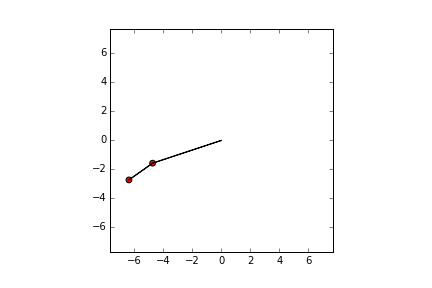
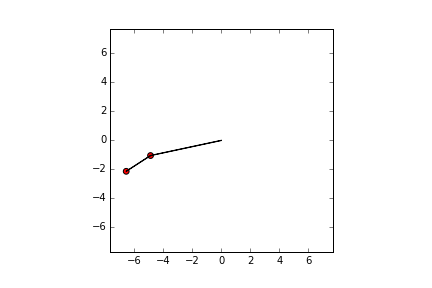
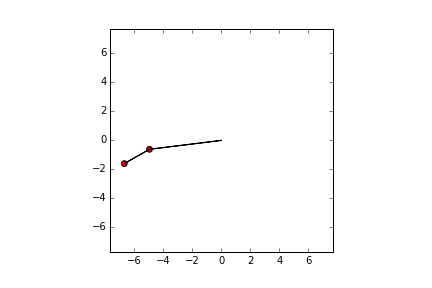
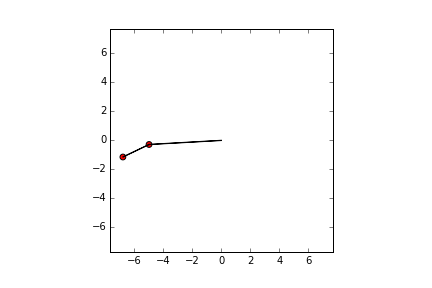
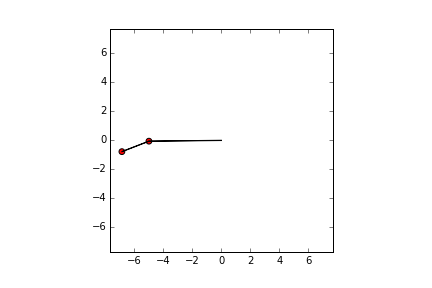
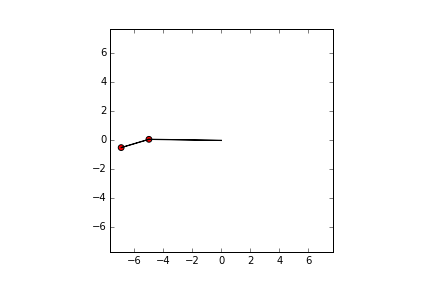
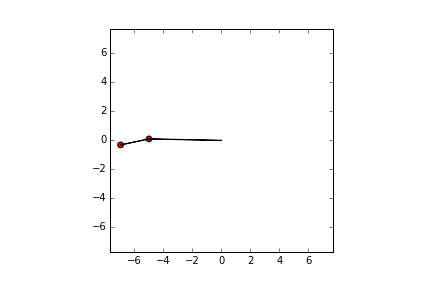
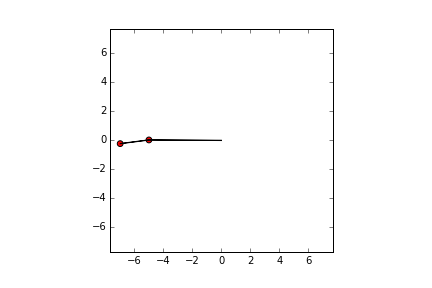
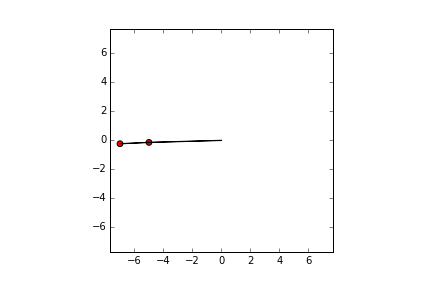
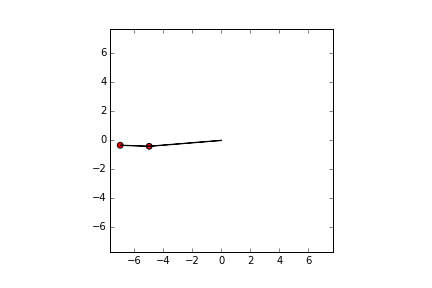
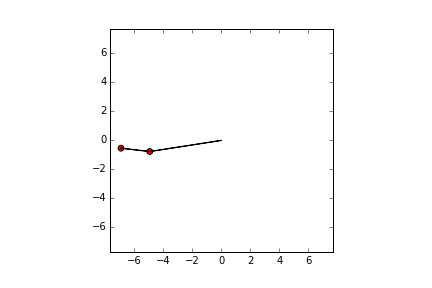
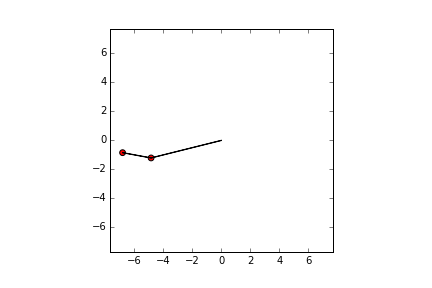
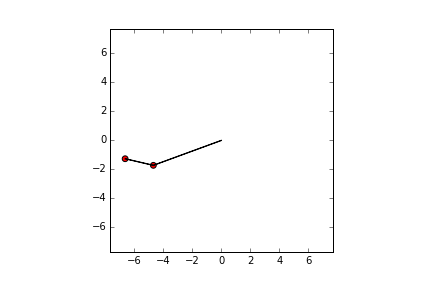
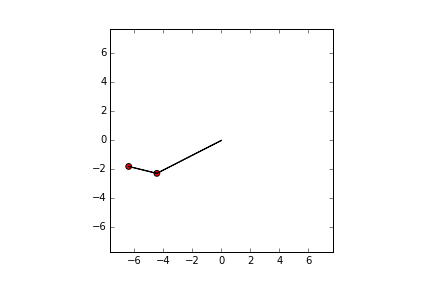
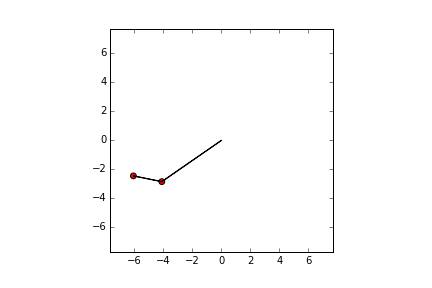
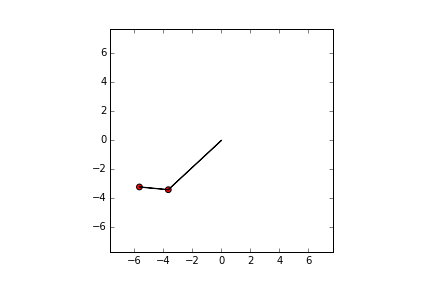
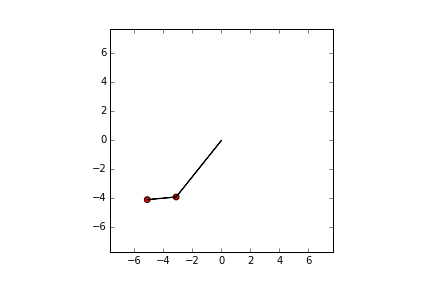
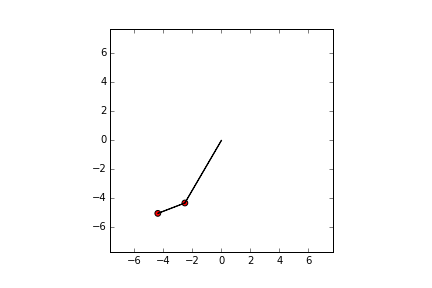
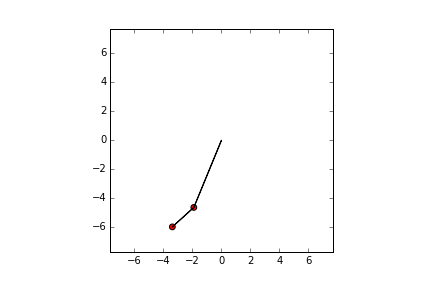
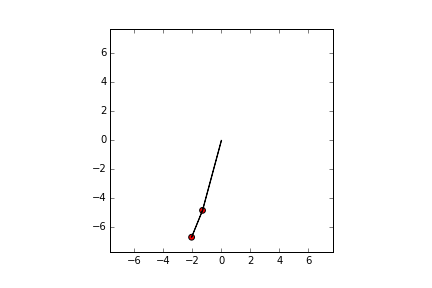
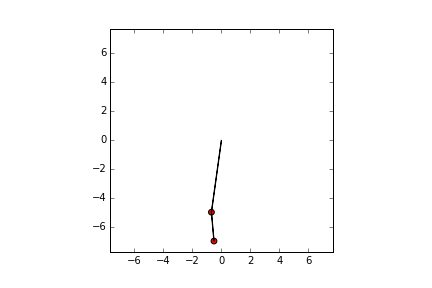
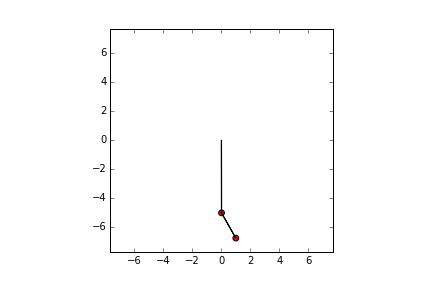
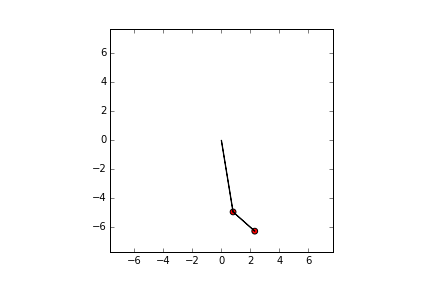
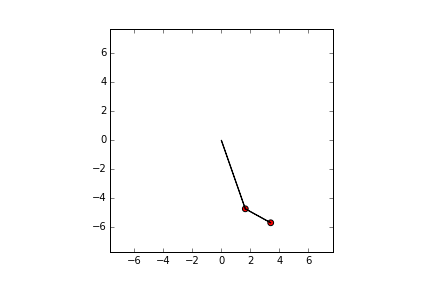
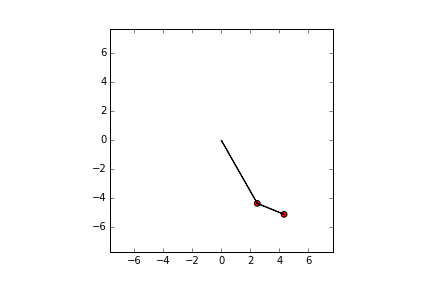
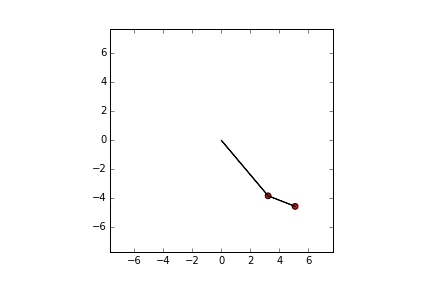
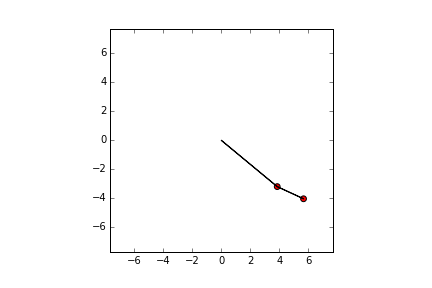
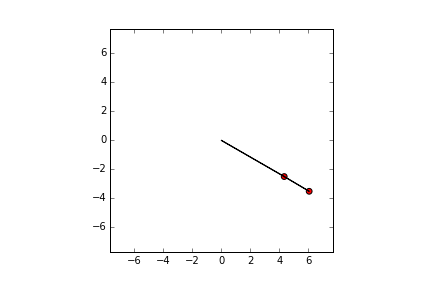
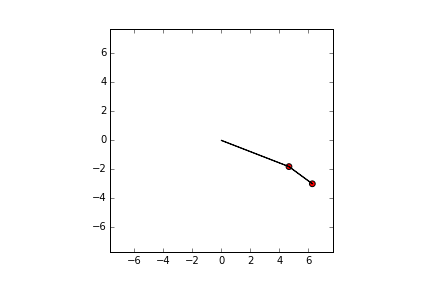
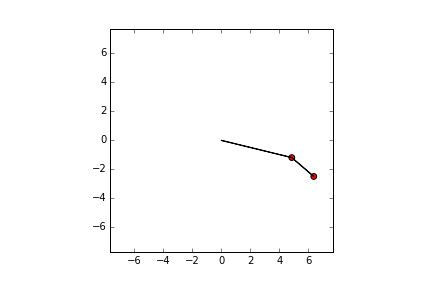
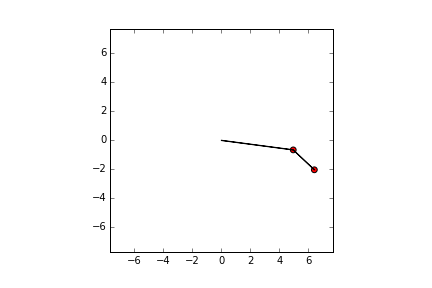
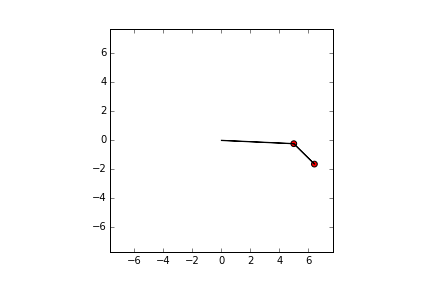
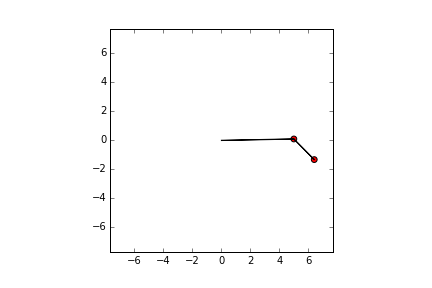
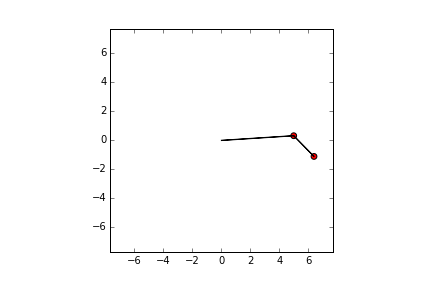
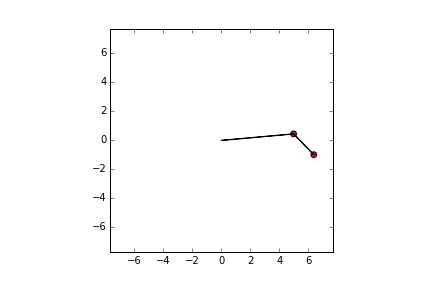
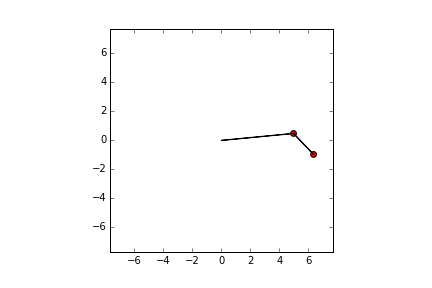
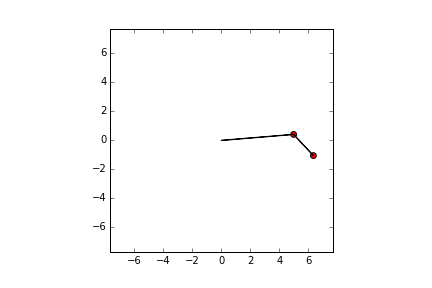

In [15]:
# First set up the figure, and the axis we want to animate
fig = plt.figure()
ax = plt.axes(aspect='equal', xlim=(-sizex, sizex), ylim=(-sizey, sizey))

ims = []

def drawonesol(nr):
    artist1, = circle(ax, x1t[nr], y1t[nr], rad)
    artist2, = circle(ax, x2t[nr], y2t[nr], rad)
    artist3, = line(ax, 0, 0, x1t[nr], y1t[nr])
    artist4, = line(ax,x1t[nr], y1t[nr], x2t[nr], y2t[nr])
    return (artist3, artist4, artist1, artist2)

def create_animation(sizex, sizey):
    """
    The calculation step is problem.tstep=1e-2, so output every 10 solutions or 0.1, means
    a frame rate of 10 frames per second
    """
    for solnr in range(0,int(round(min(endtime/problem.tstep, lastind))), skipsteps):
        arts = drawonesol(solnr)
        ims.append(arts)

create_animation(sizex, sizey)
#one frame every 100 milliseconds
animation.ArtistAnimation(fig, ims, interval=1000/frames_per_second, blit=True)